In [5]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


### Metrics

In [6]:
def loglikelihood(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

def kl(time, cens, sf, cumhf, bins):
    eq_sf = np.array([np.where(time > t, 1, 0)
                      for i, t in enumerate(bins)]).T
    
    kl_v = np.sum(sf * np.log((sf + 1e-10)/(eq_sf + 1e-10)) + np.abs(sf - eq_sf), axis=0)
    return np.trapz(kl_v, bins, axis=0) / (bins[-1] - bins[0])

In [7]:
def ibs(*args, **kwargs):
    return metr.ibs(*args, **kwargs)

def bal_ibs(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2

def ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time <= t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    if axis == -1:  # mean ibs for each time and observation
        brier_scores = np.mean(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        return np.mean(brier_scores, axis=1)
    return None

def bal_ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_WW(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_WW(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2


def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    
    ind = np.digitize(test_time, times) - 1
    n_cens = np.bincount(ind[~test_event], minlength=times.shape[0])
    
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                        for i, t in enumerate(times)]), axis=1)

    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)        
        return brier_scores
    return None

def bal_ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_remain(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_remain(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2

ibs_list = [ibs, bal_ibs, 
            ibs_WW, bal_ibs_WW,
            ibs_remain, bal_ibs_remain]

In [4]:
import sksurv.metrics
import numpy as np
from numba import njit, jit
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index

def iauc(survival_train, survival_test, estimate, times, tied_tol=1e-8, axis=-1):
    if survival_train["cens"].sum() == 0:
        survival_train["cens"] = 1
        survival_test["cens"] = 1 - survival_test["cens"]
    if survival_test["cens"].sum() == 0:
        survival_test["cens"] = 1
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test)
    # estimate, times = _check_estimate_2d(estimate, test_time, times)
    estimate = np.array(estimate)
    n_samples = estimate.shape[0]
    n_times = times.shape[0]
    if estimate.ndim == 1:
        estimate = np.broadcast_to(estimate[:, np.newaxis], (n_samples, n_times))

    # fit and transform IPCW
    cens = sksurv.metrics.CensoringDistributionEstimator()
    cens.fit(survival_train)
    Ghat = cens.predict_proba(test_time[test_event])
    ipcw = np.zeros(test_time.shape[0])
    Ghat[Ghat == 0] = np.inf
    if not((Ghat == 0.0).any()):
        ipcw[test_event] = 1.0 / Ghat
    else:
        ipcw = np.ones(test_time.shape[0])

    # expand arrays to (n_samples, n_times) shape
    test_time = np.broadcast_to(test_time[:, np.newaxis], (n_samples, n_times))
    test_event = np.broadcast_to(test_event[:, np.newaxis], (n_samples, n_times))
    times_2d = np.broadcast_to(times, (n_samples, n_times))
    ipcw = np.broadcast_to(ipcw[:, np.newaxis], (n_samples, n_times))

    # sort each time point (columns) by risk score (descending)
    o = np.argsort(-estimate, axis=0)
    test_time = np.take_along_axis(test_time, o, axis=0)
    test_event = np.take_along_axis(test_event, o, axis=0)
    estimate = np.take_along_axis(estimate, o, axis=0)
    ipcw = np.take_along_axis(ipcw, o, axis=0)

    is_case = (test_time <= times_2d) & test_event
    is_control = test_time > times_2d
    n_controls = is_control.sum(axis=0)

    # prepend row of infinity values
    estimate_diff = np.concatenate((np.broadcast_to(np.infty, (1, n_times)), estimate))
    is_tied = np.absolute(np.diff(estimate_diff, axis=0)) <= tied_tol

    cumsum_tp = np.cumsum(is_case * ipcw, axis=0)
    cumsum_fp = np.cumsum(is_control, axis=0)
    true_pos = cumsum_tp / cumsum_tp[-1]
    false_pos = cumsum_fp / n_controls

    scores = np.empty(n_times, dtype=float)
    it = np.nditer((true_pos, false_pos, is_tied), order="F", flags=["external_loop"])
    with it:
        for i, (tp, fp, mask) in enumerate(it):
            idx = np.flatnonzero(mask) - 1
            # only keep the last estimate for tied risk scores
            tp_no_ties = np.delete(tp, idx)
            fp_no_ties = np.delete(fp, idx)
            # Add an extra threshold position
            # to make sure that the curve starts at (0, 0)
            tp_no_ties = np.r_[0, tp_no_ties]
            fp_no_ties = np.r_[0, fp_no_ties]
            scores[i] = np.trapz(tp_no_ties, fp_no_ties)

    scores[np.isnan(scores)] = 0
    if n_times == 1:
        return scores[0]
    
    if axis == -1:  # mean iauc for each time and observation
        surv = KaplanMeierFitter()
        surv.fit(survival_test["time"], survival_test["cens"]) 
        s_times = surv.survival_function_at_times(times).to_numpy()
        
        # compute integral of AUC over survival function
        d = -np.diff(np.r_[1.0, s_times])
        integral = (scores * d).sum()
        return integral / (1.0 - s_times[-1])
    elif axis == -2:
        surv = KaplanMeierFitter()
        surv.fit(survival_test["time"], survival_test["cens"]) 
        s_times = surv.survival_function_at_times(times).to_numpy()
        
        return np.trapz(scores, -s_times) / (s_times[0] - s_times[-1])
    elif axis == 0:  # ibs for each observation
        return None
    elif axis == 1:  # bs in time (for graphics)
        return scores
    return mean_auc

### Datasets loading

In [200]:
import survivors.datasets as ds
# X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X, y, features, categ, sch_nan = ds.load_smarto_dataset()

### Bins schemes

In [138]:
def bins_scheme(val, scheme=""):
    if scheme == "rank":
        u = np.unique(val)
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")
    if scheme == "quantile":
        u = np.unique(np.quantile(val, np.linspace(0, 1, 100)))
        # u = np.hstack([0.0, np.quantile(val, np.linspace(0, 1, 100)), val.max()])
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")  # u[ind].astype("int")
    if scheme == "log+scale":
        a = np.log(val+1)
        v = (val.max() - val.min())*(a - a.min())/(a.max() - a.min()) + val.min()
        return v.astype("int")
    return val

(-128.75, 2791.75)

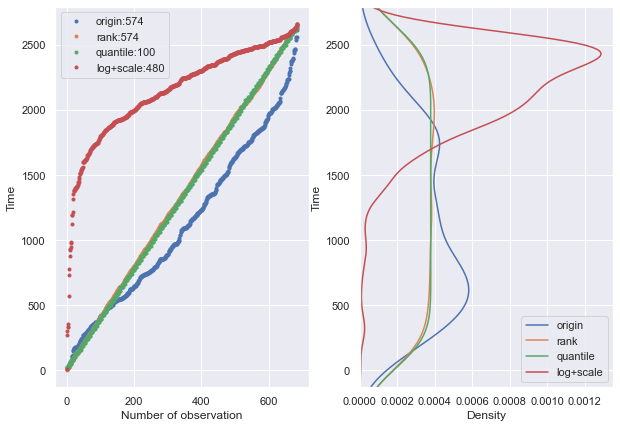

In [139]:
fig, axes = plt.subplots(figsize=(10, 7), ncols=2)
for scheme in ["origin", "rank", "quantile", "log+scale"]:
    y_new = y.copy()
    #y_new[np.argmax(y_new["time"] * y_new["cens"])]["time"] = 1000
    y_ = np.sort(bins_scheme(y_new["time"], scheme=scheme))
    axes[0].plot(y_, label=f"{scheme}:{np.unique(y_).shape[0]}", marker='o', markersize=3, linestyle="")
    
    sns.kdeplot(y=bins_scheme(y_new["time"], scheme=scheme), label=f"{scheme}", ax=axes[1])
axes[0].legend()
axes[0].set_xlabel("Number of observation")
axes[0].set_ylabel("Time")

axes[1].legend()
axes[1].set_ylabel("Time")


ymin, ymax = axes[0].get_ylim()
axes[1].set_ylim(ymin, ymax)

### Dependence IBS on true event time

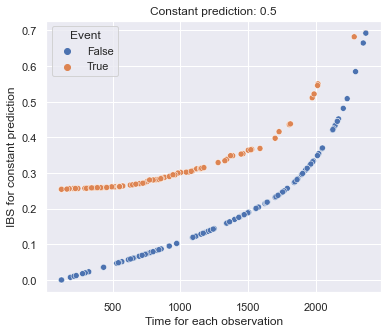

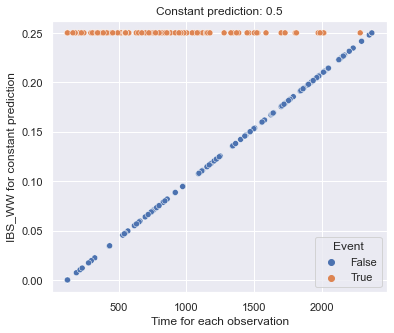

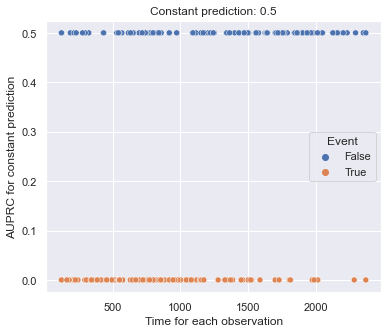

In [140]:
from survivors.experiments.grid import generate_sample

def plot_dependence_of_obs(X, y, metric, cnt_p=0.5): # [0.0, 0.5, 1.0]
    plt.figure(figsize=(6, 5))
    for scheme in ["origin"]:
        y_new = y.copy()
        y_new["time"] = bins_scheme(y_new["time"], scheme=scheme)
        for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y_new, 5, "CV+HOLD-OUT"):
            pass
        ibs_all = metric(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=-1)
        ibs_cnt_p = metric(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=0)
        pd_data = pd.DataFrame(y_HO)
        pd_data["Event"] = pd_data["cens"]
        sns.scatterplot(data=pd_data, x="time", y=ibs_cnt_p, hue="Event", palette="deep")
    plt.title(f"Constant prediction: {cnt_p}")
    plt.xlabel("Time for each observation")
    plt.ylabel(f"{metric.__name__.upper()} for constant prediction")
    plt.show()

plot_dependence_of_obs(X, y, metr.ibs)
plot_dependence_of_obs(X, y, metr.ibs_WW)
plot_dependence_of_obs(X, y, metr.auprc)

### Dependence IBS and IAUC on bins

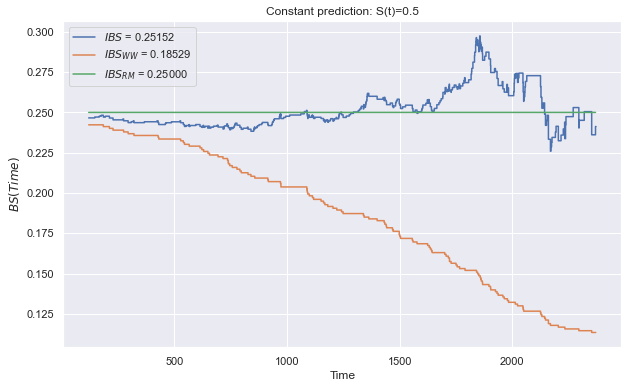

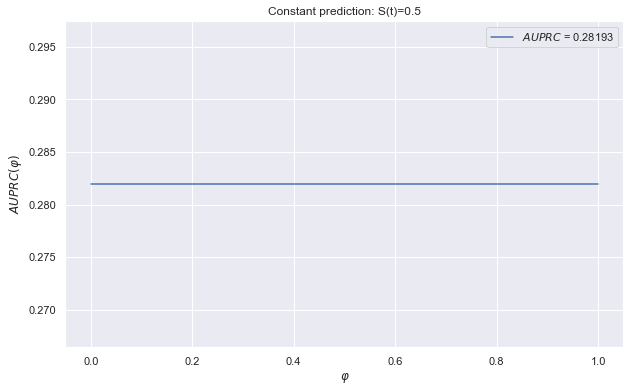

In [199]:
from survivors.experiments.grid import generate_sample

map_formula = {
    "IBS": r'$IBS$',
    "IBS_WW": r'$IBS_{WW}$',
    "IBS_RM": r'$IBS_{RM}$',
    "AUPRC": r'$AUPRC$',
    "AUPRC_WW": r'$AUPRC_{WW}$',
    "AUPRC_RM": r'$AUPRC_{RM}$',
}

def plot_dependence_of_time(X, y, l_metrics):
    for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
        pass
#     plt.figure(figsize=(6, 5))
    plt.figure(figsize=(10, 6))
    for m in l_metrics:
        bins = bins[:-1]
        base_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5

        m_all = m(y_tr, y_HO, base_sf, bins, axis=1)
        m_mean = m(y_tr, y_HO, base_sf, bins, axis=-1)
        
        if m.__name__.find("auprc") != -1:
            bins = np.linspace(0, 1, 100)
        plt.step(bins, m_all,  label=f"{map_formula[m.__name__.upper()]} = {m_mean:.5f}")
    
    plt.legend()
    plt.title(f"Constant prediction: S(t)=0.5")
    plt.xlabel("Time")
    if m.__name__.find("auprc") != -1:
        plt.xlabel(r"$\varphi$")
        plt.ylabel(r"$AUPRC(\varphi)$")
    else:
        plt.xlabel("Time")
        plt.ylabel("$BS(Time)$")

def ibs_rm(*args, **kwargs):
    return metr.ibs_remain(*args, **kwargs)

plot_dependence_of_time(X, y, [metr.ibs, metr.ibs_WW, ibs_rm])
plot_dependence_of_time(X, y, [metr.auprc])

Text(0, 0.5, 'AUC(Time)')

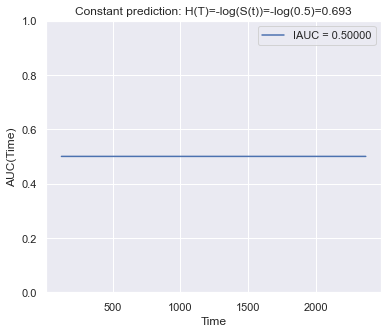

In [36]:
from survivors.experiments.grid import generate_sample
for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

plt.figure(figsize=(6, 5))
# plt.figure(figsize=(10, 6))

for m in [iauc]:
    bins = bins[:-1]
    base_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5
    base_hf = -np.log(base_sf)
    kmf = KaplanMeierFitter()

    kmf.fit(y_HO["time"], y_HO["cens"])
    one_km_sf = kmf.survival_function_at_times(bins).to_numpy()
    km_sf = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
    base_hf = -np.log(km_sf)

    m_all = m(y_tr, y_HO, base_hf, bins, axis=1)
    m_mean = m(y_tr, y_HO, base_hf, bins, axis=-1)
    plt.step(bins, m_all,  label=f"{m.__name__.upper()} = {m_mean:.5f}") #label=f"max bins:{max_time}, ibs={ibs_mean:.5f}")

# plt.step(bins, km_sf[0])
plt.legend()
plt.ylim((0.0, 1.0))
plt.title(f"Constant prediction: H(T)=-log(S(t))=-log(0.5)=0.693")
plt.xlabel("Time")
plt.ylabel("AUC(Time)")

Text(0, 0.5, 'Impact')

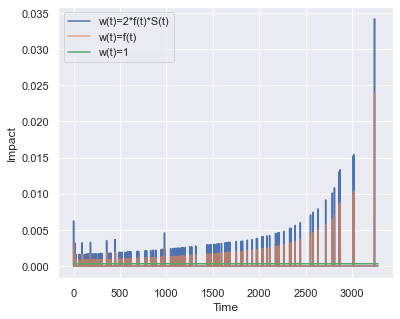

In [510]:
# h_est = np.hstack([0.0, -np.diff(np.log(one_km_sf))])
f_est = np.hstack([0.0, -np.diff(one_km_sf)])
plt.figure(figsize=(6, 5))
plt.step(bins, 2*one_km_sf*f_est,  label=f"w(t)=2*f(t)*S(t)", alpha=1)
plt.step(bins, f_est,  label=f"w(t)=f(t)", alpha=0.7)
plt.step(bins, np.ones_like(bins)/(bins[-1] - bins[0]), label=f"w(t)=1")
# plt.step(bins, km_sf[0])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Impact")

Text(0, 0.5, 'Impact')

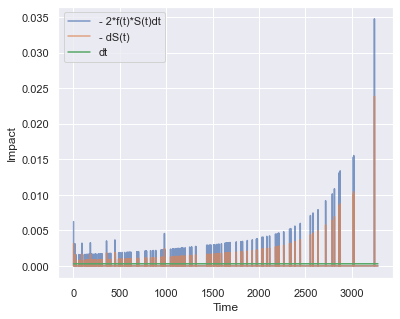

In [512]:
plt.figure(figsize=(6, 5))
plt.step(bins[1:], -1*np.diff(km_sf**2)[0],  label=f"- 2*f(t)*S(t)dt", alpha=0.7)
plt.step(bins[1:], -1*np.diff(km_sf)[0],  label=f"- dS(t)", alpha=0.7)
# plt.step(bins, km_sf[0])
plt.step(bins[1:], np.diff(bins)/(bins[-1] - bins[0]), label=f"dt")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Impact")

### Disbalance analysis

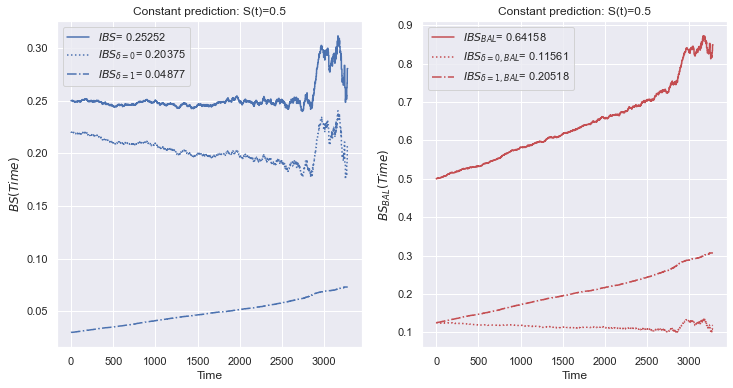

In [202]:
from survivors.experiments.grid import generate_sample

def plot_disbalance(X, y, m, m_bal):
    for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
        pass

    fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
    bins = bins[:-1]
    best_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5
    best_hf = -np.log(best_sf)

    N_event = np.sum(y_HO["cens"])
    N_cens = y_HO.shape[0] - N_event
    N = y_HO.shape[0]

    m_event = m(y_tr, y_HO[y_HO["cens"]], best_sf[y_HO["cens"]], bins, axis=1)
    m_event_val = m(y_tr, y_HO[y_HO["cens"]], best_sf[y_HO["cens"]], bins, axis=-1)

    m_cens = m(y_tr, y_HO[~y_HO["cens"]], best_sf[~y_HO["cens"]], bins, axis=1)
    m_cens_val = m(y_tr, y_HO[~y_HO["cens"]], best_sf[~y_HO["cens"]], bins, axis=-1)

    m_all = m(y_tr, y_HO, best_sf, bins, axis=1)
    m_all_val = m(y_tr, y_HO, best_sf, bins, axis=-1)

    m_bal_arr = m_bal(y_tr, y_HO, best_sf, bins, axis=1)
    m_bal_mean = m_bal(y_tr, y_HO, best_sf, bins, axis=-1)

    #plt.fill_between(bins_, ibs_all, step="pre", alpha=0.3)
    if m.__name__.find("auprc") != -1:
        bins = np.linspace(0, 1, 100)
        axes[0].step(bins, m_all,  label=r"$AUPRC$"+ f"= {m_all_val:.5f}", color="b")
        axes[0].step(bins, m_cens,  label=r"$AUPRC_{\delta=0}$"+ f"= {m_cens_val:.5f}", ls=':', color="b")
        axes[0].step(bins, m_event,  label=r"$AUPRC_{\delta=1}$"+ f"= {m_event_val:.5f}", ls='-.', color="b")

        axes[1].step(bins, m_bal_arr,  label=r"$AUPRC_{BAL}$"+ f"= {m_bal_mean:.5f}", color="r")
        axes[1].step(bins, m_cens,  label=r"$AUPRC_{\delta=0, BAL}$"+ f"= {m_cens_val:.5f}", ls=':', color="r")
        axes[1].step(bins, m_event,  label=r"$AUPRC_{\delta=1, BAL}$"+ f"= {m_event_val:.5f}", ls='-.', color="r")
    else:
        axes[0].step(bins, m_all,  label=r"$IBS$"+ f"= {m_all_val:.5f}", color="b")
        axes[0].step(bins, N_cens/N*m_cens,  label=r"$IBS_{\delta=0}$"+ f"= {N_cens/N*m_cens_val:.5f}", ls=':', color="b")
        axes[0].step(bins, N_event/N*m_event,  label=r"$IBS_{\delta=1}$"+ f"= {N_event/N*m_event_val:.5f}", ls='-.', color="b")

        axes[1].step(bins, m_bal_arr,  label=r"$IBS_{BAL}$"+ f"= {m_bal_mean:.5f}", color="r")
        axes[1].step(bins, m_cens/2,  label=r"$IBS_{\delta=0, BAL}$"+ f"= {m_cens_val/2:.5f}", ls=':', color="r")
        axes[1].step(bins, m_event/2,  label=r"$IBS_{\delta=1, BAL}$"+ f"= {m_event_val/2:.5f}", ls='-.', color="r")
    #     plt.step(bins, ibs_bal,  label=f"IBS_BAL = {ibs_bal_mean:.5f}", color="r")

    axes[0].legend()
    axes[1].legend()
    axes[0].set_title(f"Constant prediction: S(t)=0.5")
    axes[1].set_title(f"Constant prediction: S(t)=0.5")
    if m.__name__.find("auprc") != -1:
        axes[0].set_xlabel(r"$\varphi$")
        axes[1].set_xlabel(r"$\varphi$")
        axes[0].set_ylabel(r"$AUPRC(\varphi)$")
        axes[1].set_ylabel(r"$AUPRC_{BAL}(\varphi)$")
    else:
        axes[0].set_xlabel("Time")
        axes[1].set_xlabel("Time")
        axes[0].set_ylabel(r"$BS(Time)$")
        axes[1].set_ylabel(r"$BS_{BAL}(Time)$")

plot_disbalance(X, y, metr.ibs, metr.bal_ibs) # metr.auprc, metr.bal_auprc) # 

In [175]:
group = "bstr_full_WB" # "bstr_full_WB"  # "scsurv"
glob_dir = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/"
glob_dir = os.path.join(glob_dir, group)

In [176]:
def to_str_from_dict_list(d, strat):
    if isinstance(strat, str):
        return str(d.get(strat, ""))
    elif isinstance(strat, list):
        return ";".join([str(d.get(e, "")) for e in strat])
    return None

def print_res_sample(datas: list):
    feats = [#"CRIT", 
             "CI_mean",
             #"IAUC_mean", "IAUC_TI_mean",
             "AUPRC_mean", "EVENT_AUPRC_mean", "BAL_AUPRC_mean"]
#     fig, axes = plt.subplots(figsize=(15, 6), ncols=3)
    lst_df = []
    for dat in datas:
        print("="*10, dat[-dat[::-1].find("\\"):], "="*10)
        res_table = pd.read_excel(os.path.join(glob_dir, dat))
#         res_table["Stratify"] = res_table["PARAMS"].apply(lambda x: to_str_from_dict_list(eval(x), ["criterion", "ens_metric_name"]))
#         res_table["Stratify"] = res_table["METHOD"] + "(" + res_table["Stratify"] + ")"
#         res_table.set_index("Stratify")[feats].round(4).to_csv(dat[:-5]+"_res.csv", sep="&")
        res_table.set_index("CRIT")[feats].round(4).to_csv(dat[:-5]+"_res.csv", sep="&")
#         lst_df.append(res_table)
    
#     full_df = pd.concat(lst_df)
#     for i, m in enumerate(["CI", "AUPRC", "BAL_AUPRC"]):
#         full_df[m] = full_df[m].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
#         explode_res = full_df.loc[:, [m, "Stratify"]].set_index(['Stratify']).apply(lambda x: x.explode()).reset_index()
#         explode_res.boxplot(column=m, by="Stratify", rot=45, ax=axes[i])
#     plt.show()

ch_metrs = ["IBS_WW"]  # ["likelihood", "conc", "IBS", "IBS_WW", "IBS_REMAIN"]
for dataset in ["actg", "GBSG", "PBC", "rott2", "WUHAN"]: #["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2", "actg", "flchain"]:
    print("="*10, dataset, "="*10)
    datasets_sc = [f"{metr}_{group}_origin_{dataset}_CV+SAMPLE_best.xlsx" for metr in ch_metrs]
    print_res_sample(datasets_sc)

========== actg ==========
========== BS_WW_bstr_full_WB_origin_actg_CV+SAMPLE_best.xlsx ==========
========== GBSG ==========
========== BS_WW_bstr_full_WB_origin_GBSG_CV+SAMPLE_best.xlsx ==========
========== PBC ==========
========== BS_WW_bstr_full_WB_origin_PBC_CV+SAMPLE_best.xlsx ==========
========== rott2 ==========
========== BS_WW_bstr_full_WB_origin_rott2_CV+SAMPLE_best.xlsx ==========
========== WUHAN ==========
========== BS_WW_bstr_full_WB_origin_WUHAN_CV+SAMPLE_best.xlsx ==========


========== GBSG ==========


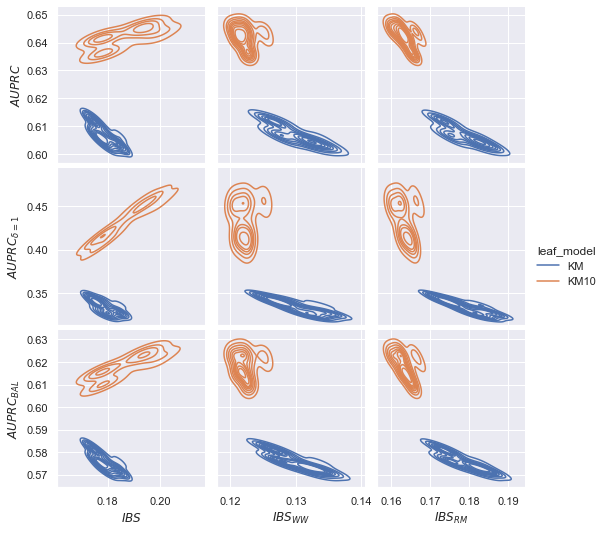

========== rott2 ==========


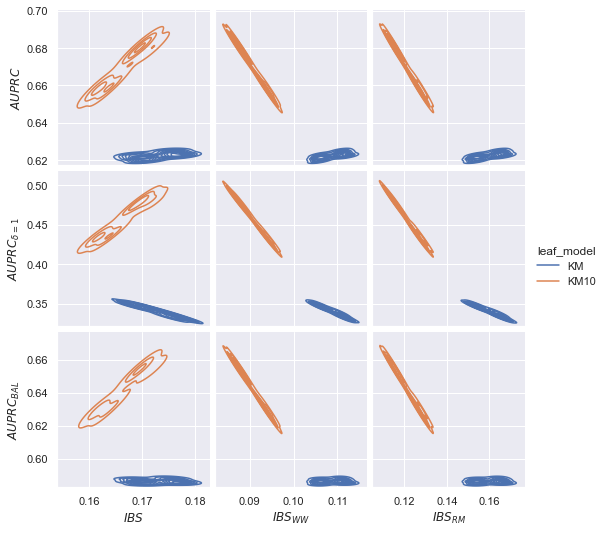

In [187]:
def pair_compare(df, strata):
#     df = df[df["PARAMS"].apply(lambda x: eval(x)["leaf_model"]=="base_zero_after")]
    df[strata] = df["PARAMS"].apply(lambda x: eval(x)[strata])
    if strata == "leaf_model":
        df[strata] = df[strata].replace(regex={'base_fast': 'KM', 'base_zero_after': 'KM10'})
    ibs_m = ["IBS_mean", "IBS_WW_mean", "IBS_REMAIN_mean"]
    auprc_m = ["AUPRC_mean", "EVENT_AUPRC_mean", "BAL_AUPRC_mean"]
    df = df[ibs_m + auprc_m + ['leaf_model']]
    df = df.rename({c:c[:-5] for c in ibs_m + auprc_m}, axis=1)
    
    df = df.rename({"IBS": r"$IBS$",
                    "IBS_WW": r"$IBS_{WW}$",
                    "IBS_REMAIN": r"$IBS_{RM}$",
                    "AUPRC": r"$AUPRC$",
                    "EVENT_AUPRC": r"$AUPRC_{\delta=1}$",
                    "BAL_AUPRC": r"$AUPRC_{BAL}$",
                   }, axis=1)
    
    sns.pairplot(x_vars=[r"$IBS$", r"$IBS_{WW}$", r"$IBS_{RM}$"],
         y_vars=[r"$AUPRC$", r"$AUPRC_{\delta=1}$", r"$AUPRC_{BAL}$"],
         data=df, hue=strata, palette="deep", kind="kde")
    plt.show()

def pair_compare_load(dataset, group, m, strata):
    datasets_sc = f"{m}_{group}_origin_{dataset}_CV+SAMPLE_full.xlsx"
    df = pd.read_excel(os.path.join(glob_dir, datasets_sc))
    pair_compare(df, strata)

def compare_by_m(dataset, group, ens_ms):
    lst_df = []
    for m in ens_ms:
        datasets_sc = f"{m}_{group}_origin_{dataset}_CV+SAMPLE_full.xlsx"
        df = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        lst_df.append(df)
    df = pd.concat(lst_df, ignore_index=True)
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x)["ens_metric_name"])
    pair_compare(df, "ens_metric_name")

for ds in ["GBSG", "rott2"]: # ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2", "actg"]:
    print("="*10, ds, "="*10)
    pair_compare_load(ds, group, "IBS_WW", 'leaf_model')
#     compare_by_m(ds, group, ["IBS", "IBS_WW", "IBS_REMAIN"])

### AUPRC

In [134]:
def auprc(survival_train, survival_test, estimate, times, axis=-1):
    time = survival_test["time"]
    event = survival_test["cens"]

    steps = np.linspace(1e-5, 1 - 1e-5, 100)
    before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
    after_time = np.dot(time[:, np.newaxis], 1/steps[np.newaxis, :])
    before_ind = np.clip(np.searchsorted(times, before_time), 0, times.shape[0]-1)
    after_ind = np.clip(np.searchsorted(times, after_time), 0, times.shape[0]-1)

    est = np.take_along_axis(estimate, before_ind, axis=1)
    est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)
    
    if axis == -1:  # mean for each time and observation
        est = np.mean(est, axis=0)
        return np.trapz(est, steps)
    elif axis == 0:  # for each observation
        return np.trapz(est, steps)
    elif axis == 1:  # in time (for graphics)
        est = est.mean(axis=0)    
        return est
    elif axis == 2:  # source
        return est
    return None

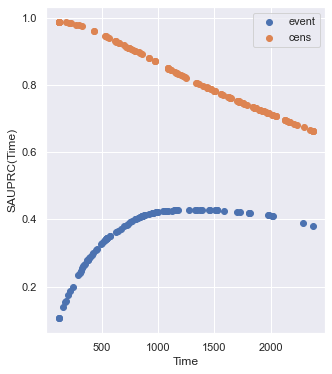

0.6137586624103915
0.3568830659112446 0.8124358815777005
0.5846594737444726


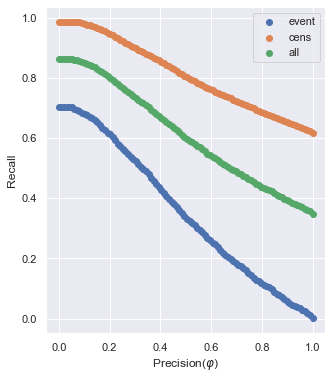

In [142]:
kmf = KaplanMeierFitter()
kmf.fit(y_HO["time"], y_HO["cens"])
    
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
# estimate[:] = 0.5
steps = np.linspace(1e-5, 1 - 1e-5, 100)
event = y_HO["cens"]

m_obs = auprc(None, y_HO, estimate, bins, axis=0)

plt.figure(figsize=(5, 6))
plt.scatter(y_HO[y_HO["cens"]]["time"], m_obs[event], label="event")
plt.scatter(y_HO[~y_HO["cens"]]["time"], m_obs[~event], label="cens")
plt.xlabel("Time")
plt.ylabel("SAUPRC(Time)")
plt.legend()
plt.show()

print(m_obs.mean())
print(m_obs[y_HO["cens"]].mean(), m_obs[~y_HO["cens"]].mean())
print((m_obs[y_HO["cens"]].mean() + m_obs[~y_HO["cens"]].mean())/2)

plt.figure(figsize=(5, 6))
m_src = auprc(None, y_HO, estimate, bins, axis=2)
plt.scatter(steps, m_src[y_HO["cens"]].mean(axis=0), label="event")
plt.scatter(steps, m_src[~y_HO["cens"]].mean(axis=0), label="cens")
plt.scatter(steps, m_src.mean(axis=0), label="all")
plt.xlabel(r"Precision($\varphi$)")
plt.ylabel("Recall")
plt.legend()
plt.show()

3 (True, 698.)


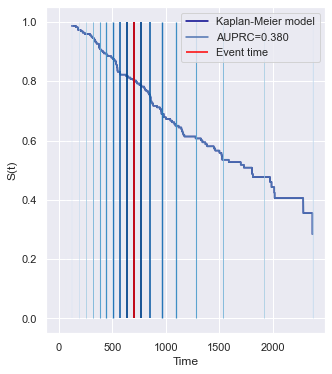

4 (True, 1807.)


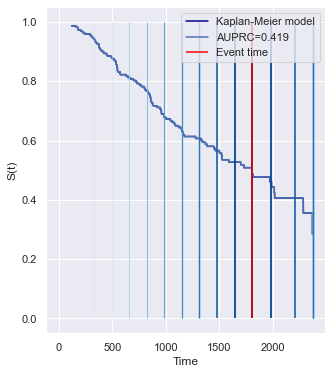

In [161]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
# estimate[:] = 0.5
time = y_HO["time"]
event = y_HO["cens"]

steps = np.linspace(1e-5, 1 - 1e-5, 12)
before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
after_time = np.dot(time[:, np.newaxis], 1/steps[np.newaxis, :])
before_ind = np.clip(np.searchsorted(bins, before_time), 0, bins.shape[0]-1)
after_ind = np.clip(np.searchsorted(bins, after_time), 0, bins.shape[0]-1)

est = np.take_along_axis(estimate, before_ind, axis=1)
est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)

for i in [3, 4]:
    print(i, y_HO[i])
    plt.figure(figsize=(5, 6))
    plt.step(bins, estimate[i], color="darkblue", label=f"Kaplan-Meier model")
    plt.step(bins, estimate[i], label=f"AUPRC={np.trapz(est[i], steps):.3f}")
    cmap = plt.get_cmap('Blues')
    plt.vlines(np.clip(before_time[i], 0, bins.max()), 0, 1, colors=cmap(np.linspace(0, 1, steps.shape[0])), 
               linewidth=np.linspace(0, 2, steps.shape[0]))
    plt.vlines(np.clip(after_time[i], 0, bins.max()), 0, 1, colors=cmap(np.linspace(0, 1, steps.shape[0])), 
               linewidth=np.linspace(0, 2, steps.shape[0]))
    plt.vlines(y_HO[i]["time"], 0, 1, colors="red", label="Event time")
    plt.xlabel(r"Time")
    plt.ylabel("S(t)")
    plt.legend()
    plt.show()

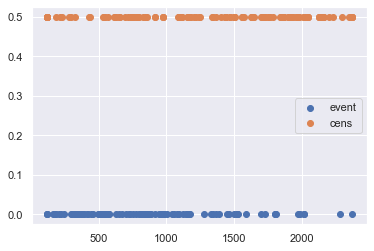

0.28193268722466963
0.0 0.49999000000000016
0.24999500000000008


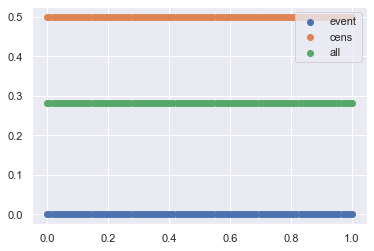

In [96]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
estimate[:] = 0.5
time = y_HO["time"]
event = y_HO["cens"]

steps = np.linspace(1e-5, 1 - 1e-5, 100)
before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
after_time = np.dot(time[:, np.newaxis], 1/steps[np.newaxis, :])
before_ind = np.clip(np.searchsorted(bins, before_time), 0, bins.shape[0]-1)
after_ind = np.clip(np.searchsorted(bins, after_time), 0, bins.shape[0]-1)

est = np.take_along_axis(estimate, before_ind, axis=1)
est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)

plt.scatter(time[event], np.trapz(est[event], steps), label="event")
plt.scatter(time[~event], np.trapz(est[~event], steps), label="cens")
plt.legend()
plt.show()
print(np.trapz(est, steps).mean())
print(np.trapz(est[event], steps).mean(), np.trapz(est[~event], steps).mean())
print((np.trapz(est[event], steps).mean() + np.trapz(est[~event], steps).mean())/2)

plt.scatter(steps, est[event].mean(axis=0), label="event")
plt.scatter(steps, est[~event].mean(axis=0), label="cens")
plt.scatter(steps, est.mean(axis=0), label="all")
plt.legend()
plt.show()

### Проверка устойчивости при калибровке

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_event = res_event.append(l_event, ignore_index=True)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_cens = res_cens.append(l_cens, ignore_index=True)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_event = res_event.append(l_event, ignore_index=True)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_cens = r

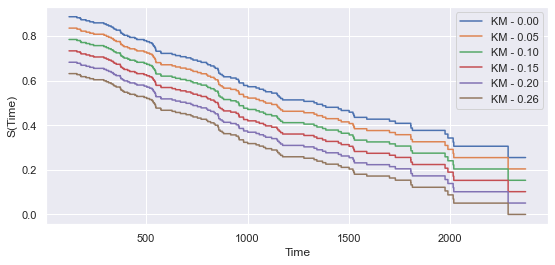

(        ibs    ibs_WW ibs_remain     auprc
 0    0.2415  0.190052   0.189927  0.330255
 1  0.223203  0.171712   0.171631  0.330255
 2  0.211377  0.158579   0.158543  0.330255
 3  0.206022  0.150653   0.150661  0.330255
 4  0.207137  0.147935   0.147987  0.330255
 5  0.214725  0.150425   0.150521  0.330255,
         ibs    ibs_WW ibs_remain     auprc
 0  0.182169  0.083251    0.08336  0.712449
 1  0.220686  0.104334   0.104465  0.661424
 2   0.26349  0.128233   0.128387  0.610399
 3  0.310579  0.154947   0.155128  0.559374
 4  0.361954  0.184477   0.184686  0.508349
 5  0.417615  0.216823   0.217062  0.457324)

In [593]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0) - 0.1
# estimate[:] = 0.5
event = y_HO["cens"]
a_min = np.min(estimate)

ms = [ibs, ibs_WW, ibs_remain, auprc]
plt.figure(figsize=(9, 4))
res_event = pd.DataFrame([], columns=[m.__name__ for m in ms])
res_cens = pd.DataFrame([], columns=[m.__name__ for m in ms])

for corr_i in [a_min*i/5 for i in range(0, 6)]:
    estimate_1 = estimate - corr_i
    l_event = {}
    l_cens = {}
    for m in [ibs, ibs_WW, ibs_remain, auprc]:
        #print(m.__name__)
        m_obs = m(y_tr, y_HO, estimate_1, bins, axis=0)
        l_event[m.__name__] = m_obs[event].mean()
        l_cens[m.__name__] = m_obs[~event].mean()
        #print(f"{m_obs[event].mean():0.3f}, {m_obs[~event].mean():0.3f}")
    plt.step(bins, estimate_1[0], label = f"KM - {corr_i:0.2f}")
    res_event = res_event.append(l_event, ignore_index=True)
    res_cens = res_cens.append(l_cens, ignore_index=True)
    
plt.xlabel("Time")
plt.ylabel("S(Time)")

plt.legend()
plt.show()
res_event, res_cens

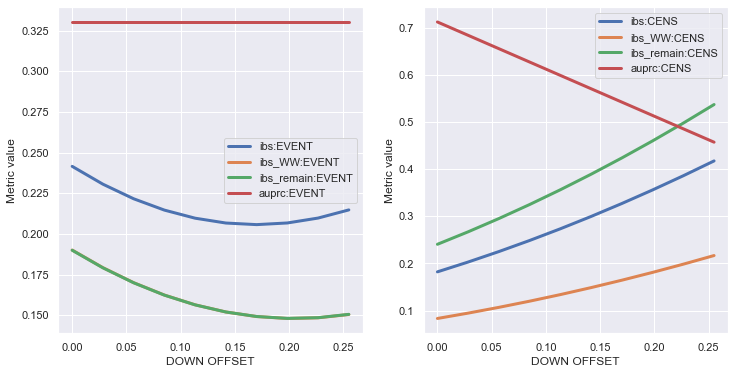

In [101]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0) - 0.1
# estimate[:] = 0.5
event = y_HO["cens"]
a_min = np.min(estimate)

x = np.linspace(0, a_min, 10)  # [a_min*i/5 for i in range(0, 26)]
# plt.figure(figsize=(9, 6))
fig, axes = plt.subplots(figsize=(12, 6), ncols=2)

for m in [ibs, ibs_WW, ibs_remain, auprc]:
    # print(m.__name__)
    l_ev = []
    l_cens = []
    for corr_i in x:
        steps = np.linspace(1e-5, 1 - 1e-5, 100)
        estimate_1 = estimate - corr_i
        m_ev = m(y_tr, y_HO[event], estimate_1[event], bins, axis=-1)
        m_cens = m(y_tr, y_HO[~event], estimate_1[~event], bins, axis=-1)
        # print(f"{m_ev:.3f}, {m_cens:.3f}")
        l_ev.append(m_ev)
        l_cens.append(m_cens)
    axes[0].plot(x, l_ev, label=f"{m.__name__}:EVENT", linewidth=3)
    axes[1].plot(x, l_cens, label=f"{m.__name__}:CENS", linewidth=3)

# plt.xlabel("DOWN OFFSET")
# plt.ylabel("Metric value")
# plt.legend()
# plt.show()

axes[0].set_xlabel("DOWN OFFSET")
axes[0].set_ylabel("Metric value")
axes[0].legend()

axes[1].set_xlabel("DOWN OFFSET")
axes[1].set_ylabel("Metric value")
axes[1].legend()

plt.show()

### PLOTS OF AUPRC by event for best models

In [204]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis

from survivors.ensemble import BootstrapCRAID

dataset = "flchain"
glob_dir = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/"
file_name = f"shared_IBS_{dataset}_CV+SAMPLE_best.xlsx"
# file_name = f"IBS_scsurv_origin_GBSG_CV+SAMPLE_best.xlsx"

In [205]:
from survivors.experiments import grid as exp
DATASETS_LOAD = {
    "GBSG": ds.load_gbsg_dataset,
    "PBC": ds.load_pbc_dataset,
    "WUHAN": ds.load_wuhan_dataset,

    "actg": ds.load_actg_dataset,
    "flchain": ds.load_flchain_dataset,
    "smarto": ds.load_smarto_dataset,
    "rott2": ds.load_rott2_dataset,
    "support2": ds.load_support2_dataset,
}

def run(M_P, dataset="GBSG", except_stop="all", dir_path=None, bins_sch="", best_metric="IBS"):
    lst_metrics = ["AUPRC_by_obs"]
    X, y, features, categ, sch_nan = DATASETS_LOAD[dataset]()
    experim = exp.Experiments(folds=20, except_stop=except_stop, dataset_name=dataset, mode="HOLD-OUT", bins_sch=bins_sch)
    experim.set_metrics(lst_metrics)
    experim.add_metric_best(best_metric)
    for m_p in M_P:
        m, hyp = m_p
        if m.__name__.find("CRAID") != -1:
            hyp["categ"] = [categ]
        experim.add_method(m, hyp)
    experim.run(X, y, dir_path=dir_path, verbose=1)
    return experim

M_P = []
res_table = pd.read_excel(os.path.join(glob_dir, file_name))
for i, row in res_table.iterrows():
    M_P.append((eval(row["METHOD"]), {k:[v] for k, v in eval(row["PARAMS"]).items()}))

t = run(M_P, dataset=dataset, except_stop="all", dir_path=None, bins_sch="")

<class 'sksurv.tree.tree.SurvivalTree'> {'max_depth': [None], 'max_features': ['sqrt'], 'min_samples_leaf': [10], 'random_state': [123], 'splitter': ['random']}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF SurvivalTree: 26.536501169204712 {'AUPRC_by_obs': [0.8410436330031775, array([0.99998   , 0.99998   , 0.99998   , ..., 0.97036627, 0.99998   ,
       0.99998   ])]}
<class 'sksurv.ensemble.forest.RandomSurvivalForest'> {'max_depth': [None], 'min_samples_leaf': [10], 'n_estimators': [100], 'random_state': [123]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF RandomSurvivalForest: 598.0279784202576 {'AUPRC_by_obs': [0.8492098962126275, array([0.99027821, 0.99998   , 0.99950639, ..., 0.9927835 , 0.99721632,
       0.99476048])]}
<class 'sksurv.ensemble.boosting.ComponentwiseGradientBoostingSurvivalAnalysis'> {'dropout_rate': [0.0], 'learning_rate': [0.5], 'loss': ['coxph'], 'n_estimators': [100], 'random_state': [123], 'subsample': [1.0]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF ComponentwiseGradientBoostingSurvivalAnalysis: 549.9908931255341 {'AUPRC_by_obs': [0.7629568078712722, array([0.92797951, 0.93680943, 0.93132857, ..., 0.94527488, 0.93911386,
       0.94534261])]}
<class 'sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis'> {'learning_rate': [0.1], 'loss': ['coxph'], 'max_depth': [20], 'max_features': ['sqrt'], 'min_samples_leaf': [20], 'n_estimators': [100], 'random_state': [123]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF GradientBoostingSurvivalAnalysis: 558.721467256546 {'AUPRC_by_obs': [0.8482597709394948, array([0.98434554, 0.98609408, 0.9858047 , ..., 0.98594499, 0.98523451,
       0.98678486])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['maxcombo'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.055  0.059  0.0579 0.0546 0.0519 0.0523 0.0509 0.05   0.0488 0.0476
 0.0475 0.0466 0.0461 0.0457 0.0456 0.0455 0.0453 0.045  0.0448 0.0445
 0.0444 0.0442 0.044  0.0442 0.0441 0.0441 0.044  0.044  0.0439 0.0439
 0.0438 0.0438 0.0438 0.0438 0.0438 0.0439 0.0438 0.0439 0.0439 0.0438
 0.0439 0.0438 0.0438 0.0437 0.0437 0.0437 0.0436 0.0436 0.0437 0.0436]
fitted: 47 models.
[0.055  0.0524 0.0572 0.0535 0.0519 0.0513 0.0496 0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3062.613472223282 {'AUPRC_by_obs': [0.8529618287367722, array([0.95991696, 0.99998   , 0.99689148, ..., 0.99998   , 0.9969871 ,
       0.99998   ])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['peto'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0541 0.0544 0.0568 0.0536 0.0521 0.0519 0.0507 0.0495 0.0489 0.0478
 0.0473 0.0465 0.0459 0.0456 0.0455 0.0456 0.0453 0.0451 0.0449 0.0447
 0.0445 0.0444 0.0443 0.0443 0.0442 0.0441 0.0441 0.0441 0.0441 0.0441
 0.044  0.0441 0.0441 0.044  0.044  0.044  0.0439 0.044  0.044  0.044
 0.044  0.044  0.044  0.044  0.0439 0.0439 0.0438 0.0439 0.0439 0.0438]
fitted: 47 models.
[0.0538 0.0518 0.0546 0.0516 0.0503 0.0502 0.0492 0.0484 0.0476 0.0465
 0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3087.8225588798523 {'AUPRC_by_obs': [0.8528430834295823, array([0.96365497, 0.99998   , 0.9894463 , ..., 0.99750355, 0.99942532,
       0.98884856])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['tarone-ware'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0521 0.0591 0.057  0.0533 0.0516 0.0514 0.0504 0.0496 0.0491 0.048
 0.0478 0.047  0.0466 0.0462 0.046  0.046  0.0456 0.0453 0.0451 0.0448
 0.0445 0.0444 0.0443 0.0443 0.0443 0.0442 0.0441 0.0441 0.0441 0.044
 0.0439 0.044  0.044  0.0439 0.0439 0.0439 0.0438 0.0438 0.0439 0.0438
 0.0439 0.0438 0.0438 0.0439 0.0438 0.0438 0.0438 0.0438 0.0438 0.0438]
fitted: 37 models.
[0.0557 0.0538 0.0567 0.0527 0.0514 0.0508 0.0493 0.0489 0.0477 0.

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3044.9547975063324 {'AUPRC_by_obs': [0.8525744422548376, array([0.98304543, 0.99998   , 0.99608164, ..., 0.98719753, 0.99987899,
       0.98608836])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['wilcoxon'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0516 0.0582 0.0589 0.0559 0.0537 0.0536 0.0517 0.0504 0.0494 0.0483
 0.0479 0.047  0.0465 0.0462 0.046  0.046  0.0458 0.0456 0.0453 0.0451
 0.0449 0.0447 0.0446 0.0447 0.0445 0.0444 0.0444 0.0443 0.0444 0.0443
 0.0443 0.0442 0.0442 0.0442 0.0442 0.0441 0.044  0.044  0.0441 0.044
 0.0441 0.044  0.044  0.0441 0.044  0.0439 0.0439 0.0439 0.0439 0.0439]
fitted: 46 models.
[0.0552 0.0524 0.055  0.0519 0.0504 0.0503 0.0494 0.0484 0.0476 0.04

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3095.867123603821 {'AUPRC_by_obs': [0.852767483547439, array([0.98718126, 0.9999214 , 0.99917525, ..., 0.99770167, 0.99985118,
       0.99261949])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['logrank'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0535 0.0535 0.0587 0.0546 0.0521 0.0518 0.0502 0.0493 0.0485 0.048
 0.0476 0.0469 0.0465 0.0459 0.0458 0.0457 0.0455 0.0452 0.0449 0.0447
 0.0445 0.0444 0.0443 0.0443 0.0442 0.0442 0.0442 0.0442 0.0442 0.0442
 0.0441 0.044  0.0441 0.0441 0.0441 0.0441 0.044  0.0439 0.044  0.0439
 0.044  0.0439 0.0439 0.0439 0.0439 0.0438 0.0438 0.0438 0.0437 0.0438]
fitted: 49 models.
[0.0563 0.0522 0.0536 0.0512 0.0503 0.0501 0.0488 0.0485 0.0479 0.0467


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3136.073700428009 {'AUPRC_by_obs': [0.85312792182898, array([0.96698485, 0.99998   , 0.99765281, ..., 0.9901416 , 0.99930733,
       0.99427001])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['maxcombo'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0508 0.0542 0.053  0.0502 0.0479 0.0483 0.0471 0.0464 0.0453 0.0442
 0.0441 0.0434 0.0429 0.0426 0.0424 0.0424 0.0422 0.0419 0.0417 0.0414
 0.0413 0.0411 0.041  0.0411 0.0411 0.0411 0.041  0.0409 0.0409 0.0409
 0.0408 0.0408 0.0408 0.0408 0.0408 0.0409 0.0408 0.0409 0.0409 0.0408
 0.0409 0.0408 0.0408 0.0408 0.0407 0.0407 0.0407 0.0407 0.0407 0.0406]
fitted: 50 models.
[0.0507 0.0484 0.0528 0.0495 0.0481 0.0477 0.0461 0.0453 0.0445 0.0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3231.8954479694366 {'AUPRC_by_obs': [0.8529773575149493, array([0.95991696, 0.99998   , 0.99689148, ..., 0.99998   , 0.9969871 ,
       0.99998   ])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['peto'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0501 0.0501 0.0521 0.0493 0.0481 0.0479 0.047  0.0459 0.0453 0.0443
 0.0439 0.0432 0.0427 0.0424 0.0423 0.0423 0.0421 0.0419 0.0418 0.0416
 0.0414 0.0413 0.0412 0.0412 0.0411 0.0411 0.0411 0.041  0.041  0.041
 0.041  0.041  0.041  0.0409 0.0409 0.041  0.0409 0.0409 0.041  0.0409
 0.041  0.0409 0.0409 0.041  0.0409 0.0408 0.0408 0.0409 0.0408 0.0408]
fitted: 46 models.
[0.0496 0.0478 0.0507 0.048  0.0468 0.0467 0.0459 0.0451 0.0443 0.043

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3239.9646191596985 {'AUPRC_by_obs': [0.8528274073021267, array([0.96365497, 0.99998   , 0.9894463 , ..., 0.99750355, 0.99942532,
       0.98884856])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['tarone-ware'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0482 0.0546 0.0526 0.0492 0.0478 0.0476 0.0467 0.046  0.0456 0.0446
 0.0444 0.0437 0.0433 0.043  0.0428 0.0428 0.0425 0.0422 0.0419 0.0417
 0.0414 0.0413 0.0412 0.0413 0.0412 0.0411 0.041  0.041  0.041  0.0409
 0.0408 0.0409 0.0409 0.0409 0.0408 0.0409 0.0408 0.0408 0.0409 0.0408
 0.0409 0.0408 0.0408 0.0409 0.0408 0.0408 0.0408 0.0408 0.0408 0.0408]
fitted: 31 models.
[0.0509 0.0494 0.052  0.0486 0.0475 0.047  0.0458 0.0454 0.04

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3231.5338521003723 {'AUPRC_by_obs': [0.8526692642134172, array([0.98304543, 0.99998   , 0.99608164, ..., 0.98719753, 0.99987899,
       0.98608836])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['wilcoxon'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0475 0.0536 0.0541 0.0515 0.0495 0.0495 0.0478 0.0467 0.0459 0.0448
 0.0445 0.0437 0.0433 0.043  0.0428 0.0429 0.0427 0.0425 0.0422 0.042
 0.0418 0.0417 0.0415 0.0416 0.0415 0.0413 0.0414 0.0413 0.0413 0.0413
 0.0412 0.0412 0.0411 0.0411 0.0411 0.041  0.0409 0.041  0.041  0.0409
 0.041  0.0409 0.0409 0.041  0.0409 0.0409 0.0409 0.0409 0.0409 0.0408]
fitted: 50 models.
[0.051  0.0485 0.0511 0.0482 0.0469 0.0469 0.046  0.0451 0.0444 0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3311.712080001831 {'AUPRC_by_obs': [0.852772250365599, array([0.98718126, 0.9999214 , 0.99917525, ..., 0.99770167, 0.99985118,
       0.99261949])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['logrank'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0495 0.0494 0.0536 0.0501 0.0479 0.0478 0.0466 0.0457 0.0449 0.0446
 0.0442 0.0436 0.0432 0.0427 0.0426 0.0425 0.0423 0.042  0.0418 0.0416
 0.0415 0.0413 0.0412 0.0413 0.0412 0.0411 0.0412 0.0412 0.0411 0.0411
 0.041  0.041  0.041  0.0411 0.0411 0.041  0.0409 0.0409 0.041  0.0409
 0.041  0.0409 0.0409 0.0409 0.0409 0.0408 0.0408 0.0408 0.0407 0.0408]
fitted: 49 models.
[0.0517 0.0481 0.0496 0.0475 0.0467 0.0465 0.0455 0.0452 0.0446 0.0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


In [214]:
t.result_table

,METHOD,PARAMS,TIME,AUPRC_by_obs,CRIT,AUPRC_by_obs_mean
0,SurvivalTree,"{'max_depth': None, 'max_features': 'sqrt', 'm...",26.536501,"[[0.5088726201715644, 0.99998, 0.5870753453453...",,0.841763
1,RandomSurvivalForest,"{'max_depth': None, 'min_samples_leaf': 10, 'n...",598.027978,"[[0.5775316032673518, 0.9984690874579123, 0.61...",,0.849242
2,ComponentwiseGradientBoostingSurvivalAnalysis,"{'dropout_rate': 0.0, 'learning_rate': 0.5, 'l...",549.990893,"[[0.26845801074103914, 0.9517472556548336, 0.5...",,0.762902
3,GradientBoostingSurvivalAnalysis,"{'learning_rate': 0.1, 'loss': 'coxph', 'max_d...",558.721467,"[[0.575600266823277, 0.9890737005552414, 0.608...",,0.848339
4,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3062.613472,"[[0.5578023124817755, 0.9988172125624866, 0.60...",maxcombo,0.853027
5,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3087.822559,"[[0.5927989167171015, 0.9993806030520384, 0.62...",peto,0.852886
6,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3044.954798,"[[0.5896413405463207, 0.9986480448251204, 0.61...",tarone-ware,0.852602
7,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3095.867124,"[[0.5859008998298434, 0.9992946355518292, 0.60...",wilcoxon,0.852790
8,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3136.0737,"[[0.608182694727038, 0.9969248132351506, 0.609...",logrank,0.853161
9,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3231.895448,"[[0.5521927484093636, 0.9988869798087374, 0.61...",maxcombo,0.853042


In [215]:
X, y, features, categ, sch_nan = DATASETS_LOAD[dataset]()
for X_train, y_train, X_test, y_test, bins in exp.generate_sample(X, y, 20, mode="HOLD-OUT"):
    break

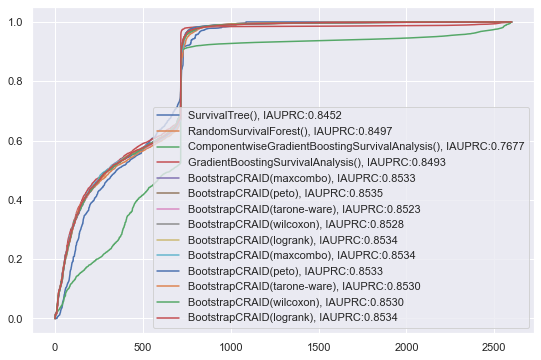

In [217]:
# def integ_by_obs_auprc(times_, auprc_):
#     ind = np.argsort(times_)
#     return np.trapz(auprc_[ind], times_[ind])/(np.max(times_) - np.min(times_))

def integ_by_obs_auprc(times_, auprc_):
    utimes = np.unique(times_)
    ind = np.digitize(times_, utimes) - 1
    return np.trapz(np.bincount(ind, weights=auprc_[ind])/np.bincount(ind), utimes)/(np.max(times_) - np.min(times_))

# plt.figure(figsize=(9, 6))
# for i, row in t.result_table.iterrows():
#     plt.scatter(y_test["time"], row["AUPRC_by_obs"][0], 
# #                 label=f"{row['METHOD']} (INTEGR:{row['AUPRC_by_obs'][0][y_test['cens']].mean():.4f})")
#                 label=f"{row['METHOD']}({row['CRIT']}), IAUPRC:{integ_by_obs_auprc(y_test['time'], row['AUPRC_by_obs'][0]):.4f}")
# plt.legend()

plt.figure(figsize=(9, 6))
for i, row in t.result_table.iterrows():
    ind = np.argsort(row["AUPRC_by_obs"][0])
    plt.plot(row["AUPRC_by_obs"][0][ind], 
             label=f"{row['METHOD']}({row['CRIT']}), IAUPRC:{integ_by_obs_auprc(y_test['time'], row['AUPRC_by_obs'][0]):.4f}")
plt.legend()

In [203]:
save_path = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/AUPRC_by_obs/"
t.result_table.to_excel(os.path.join(save_path, f"AUPRC_by_obs_{dataset}.xlsx"), index=False)

In [63]:
import pickle

# name = "D:\\Vasilev\\SA\\actg\\BootstrapCRAID_None_logrank_10_base_zero_after_0.3_0.05_50_5_1.0_HOLD-OUT_0.pkl"
name = "D:\\Vasilev\\SA\\flchain\\BootstrapCRAID_None_logrank_10_base_zero_after_0.3_0.001_50_5_1.0_HOLD-OUT_1.pkl"

with open(name, 'rb') as inp:
    est = pickle.load(inp)
    est.tolerance_find_best("IBS")

[0.0563 0.0522 0.0536 0.0512 0.0503 0.0501 0.0488 0.0485 0.0479 0.0467
 0.0469 0.0467 0.0461 0.0459 0.0456 0.0454 0.0453 0.045  0.0449 0.0447
 0.0445 0.0444 0.0443 0.0442 0.0441 0.044  0.0439 0.0439 0.0439 0.0438
 0.0438 0.0437 0.0437 0.0437 0.0437 0.0436 0.0437 0.0436 0.0436 0.0436
 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0435 0.0435]
fitted: 49 models.


In [62]:
# IBS_WW
# [0.0517 0.0481 0.0496 0.0475 0.0467 0.0465 0.0455 0.0452 0.0446 0.0435
#  0.0437 0.0435 0.043  0.0428 0.0425 0.0423 0.0422 0.042  0.0418 0.0417
#  0.0415 0.0414 0.0413 0.0412 0.0411 0.041  0.041  0.0409 0.0409 0.0408
#  0.0408 0.0407 0.0407 0.0407 0.0407 0.0406 0.0407 0.0406 0.0406 0.0406
#  0.0407 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0405]
# fitted: 50 models.

print(len(est.models))
for mod in est.models[:5]:
    print("="*10, mod, "="*10)
    for k,v in mod.nodes.items():
        if len(v.rule_edges) > 0:
            print(k, v.rule_edges[0].to_str())
        else:
            print(k, "SIZE:", v.leaf_model.get_shape()[0])

50
========== <survivors.tree.decision_tree.CRAID object at 0x0000016C719463B0> ==========
0 ((num_lambda <= 2.986)| nan)
1 ((num_kappa <= 1.89)| nan)
2 ((num_lambda <= 3.83)| nan)
3 ((num_kappa <= 1.32)| nan)
4 ((fac_chapter in [16.0])| nan)
5 ((num_kappa <= 2.7)| nan)
6 ((num_kappa <= 3.15)| nan)
7 ((num_age <= 77.5)| nan)
8 ((fac_chapter in [16.0])| nan)
9 ((num_sample_yr <= 1995.5)| nan)
10 ((fac_sample_yr in [5.0, 6.0, 8.0])| nan)
11 ((num_creatinine <= 1.25)| nan)
12 ((num_kappa <= 3.045)| nan)
13 ((num_creatinine <= 1.05)| nan)
14 ((num_age <= 89.5)| nan)
15 ((fac_chapter in [16.0])| nan)
16 ((fac_chapter in [16.0])| nan)
17 ((num_creatinine <= 0.75)| nan)
18 ((fac_chapter in [0.0, 3.0, 4.0, 6.0, 7.0, 8.0, 11.0])| nan)
19 ((fac_sex in [0.0])| nan)
20 ((num_flc_grp <= 7.5)| nan)
21 ((fac_chapter in [5.0, 12.0, 13.0])| nan)
22 ((num_kappa <= 3.205)| nan)
23 ((num_age <= 83.5)| nan)
24 ((num_creatinine <= 1.5)| nan)
25 (num_creatinine <= 0.95)
26 ((fac_chapter in [16.0])| nan)
27 (

In [64]:
# IBS
# [0.0563 0.0522 0.0536 0.0512 0.0503 0.0501 0.0488 0.0485 0.0479 0.0467
#  0.0469 0.0467 0.0461 0.0459 0.0456 0.0454 0.0453 0.045  0.0449 0.0447
#  0.0445 0.0444 0.0443 0.0442 0.0441 0.044  0.0439 0.0439 0.0439 0.0438
#  0.0438 0.0437 0.0437 0.0437 0.0437 0.0436 0.0437 0.0436 0.0436 0.0436
#  0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0435 0.0435]
# fitted: 49 models.
    
print(len(est.models))
for mod in est.models[:5]:
    print("="*10, mod, "="*10)
    for k,v in mod.nodes.items():
        if len(v.rule_edges) > 0:
            print(k, v.rule_edges[0].to_str())
        else:
            print(k, "SIZE:", v.leaf_model.get_shape()[0])

49
========== <survivors.tree.decision_tree.CRAID object at 0x0000016C712A5BD0> ==========
0 ((num_lambda <= 2.986)| nan)
1 ((num_kappa <= 1.89)| nan)
2 ((num_lambda <= 3.83)| nan)
3 ((num_kappa <= 1.32)| nan)
4 ((fac_chapter in [16.0])| nan)
5 ((num_kappa <= 2.7)| nan)
6 ((num_kappa <= 3.15)| nan)
7 ((num_age <= 77.5)| nan)
8 ((fac_chapter in [16.0])| nan)
9 ((num_sample_yr <= 1995.5)| nan)
10 ((fac_sample_yr in [5.0, 6.0, 8.0])| nan)
11 ((num_creatinine <= 1.25)| nan)
12 ((num_kappa <= 3.045)| nan)
13 ((num_creatinine <= 1.05)| nan)
14 ((num_age <= 89.5)| nan)
15 ((fac_chapter in [16.0])| nan)
16 ((fac_chapter in [16.0])| nan)
17 ((num_creatinine <= 0.75)| nan)
18 ((fac_chapter in [0.0, 3.0, 4.0, 6.0, 7.0, 8.0, 11.0])| nan)
19 ((fac_sex in [0.0])| nan)
20 ((num_flc_grp <= 7.5)| nan)
21 ((fac_chapter in [5.0, 12.0, 13.0])| nan)
22 ((num_kappa <= 3.205)| nan)
23 ((num_age <= 83.5)| nan)
24 ((num_creatinine <= 1.5)| nan)
25 (num_creatinine <= 0.95)
26 ((fac_chapter in [16.0])| nan)
27 (

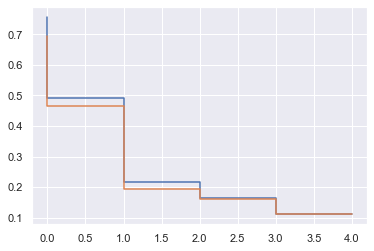

In [81]:
hf1 = np.array([0.05, 0.1, 0.8, 0.05, 0.05])*2
hf2 = np.array([0.5, 0, 0.5, 0.0, 0])*2
hf3 = np.array([0.0, 0.5, 0.0, 0.25, 0.5])*2

chf1 = np.cumsum(hf1)
chf2 = np.cumsum(hf2)
chf3 = np.cumsum(hf3)

plt.step(np.arange(5), (np.exp(-chf1) + np.exp(-chf2) + np.exp(-chf3))/3)
plt.step(np.arange(5), (np.exp(-(chf1 + chf2 + chf3)/3)))

In [93]:
def get_comb_fast(df, features):
    info = {}
    X = df.loc[:, features + [cnt.CENS_NAME, cnt.TIME_NAME]].to_numpy().T

    def create_params_f(v_feature, name):
        d = info.copy()
        d["arr"] = np.vstack((v_feature, X[-2:]))
        return d

    return list(map(create_params_f, X[:-2], features))

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X[cnt.TIME_NAME] = y[cnt.TIME_NAME]

%timeit get_comb_fast(X, features)

561 µs ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Demonstartion of convergence error of COXPH on flchain

In [ ]:
# Method: CoxPHSurvivalAnalysis, Param: {'alpha': 100, 'ties': 'breslow'} finished with except 'search direction contains NaN or infinite values'
        
from survivors.experiments import grid as exp
from sksurv.linear_model import CoxPHSurvivalAnalysis

X, y, features, categ, sch_nan = ds.load_flchain_dataset()
for X_train, y_train, X_test, y_test, bins in exp.generate_sample(X, y, 20, mode="HOLD-OUT"):
    X_train = X_train.fillna(0).replace(np.nan, 0)
    X_test = X_test.fillna(0).replace(np.nan, 0)

    cmodel = CoxPHSurvivalAnalysis(alpha=100, ties='breslow')
    cmodel = cmodel.fit(X_train, y_train)
    
    survs = cmodel.predict_survival_function(X_test)
    hazards = cmodel.predict_cumulative_hazard_function(X_test)
    pred_surv = np.array(list(map(lambda x: x(bins), survs)))
    
    # constant prediction
    # print(pred_surv)

### Tree coefficient analysis

In [177]:
def eq_coeff(v):
    return np.ones_like(v)*1/v.shape[0]

def min_coeff(v):
    return np.where(v == v.min(), 1, 0)

def clever_coeff(v):
    s = (1/v).sum()
    return 1/v*1/s

def lin_coeff(v):
    beta = v/(1-v)
    w = 1/beta # np.log(1/beta)
    return w/np.sum(w)

def sqr_coeff(v):
    v = v**2
    beta = v/(1-v)
    w = 1/beta # np.log(1/beta)
    return w/np.sum(w)

def exp_coeff(v):
    v = 1 - np.exp(-v)
    beta = v/(1-v)
    w = 1/beta # np.log(1/beta)
    return w/np.sum(w)

def target_function(v, coeff):
    return coeff.shape[0]*((coeff**2)*v).sum()

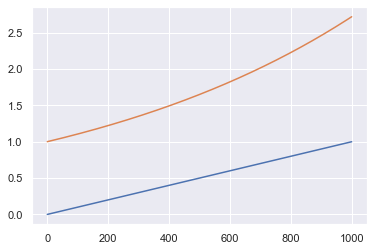

In [182]:
x = np.linspace(0.001, 1, 1000)
plt.plot(x)
plt.plot(np.exp(x))

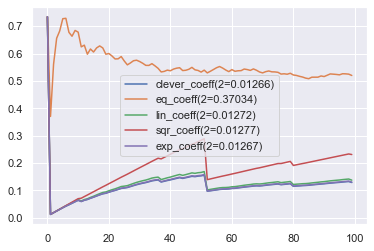

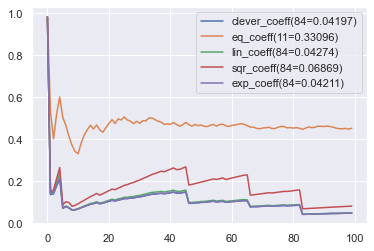

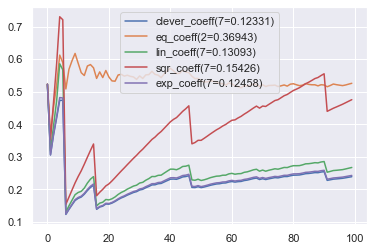

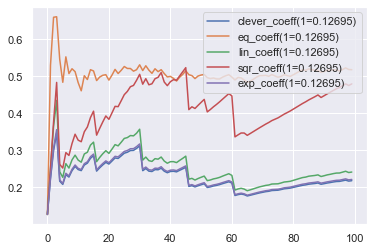

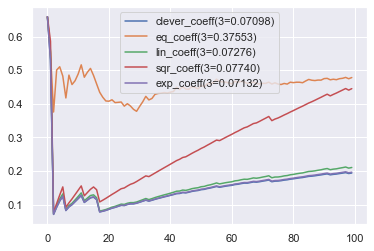

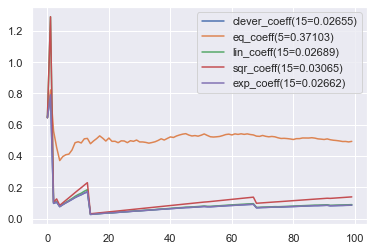

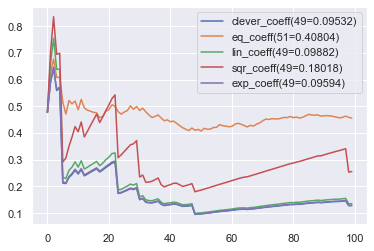

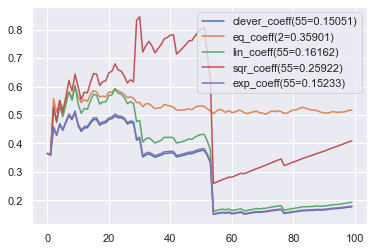

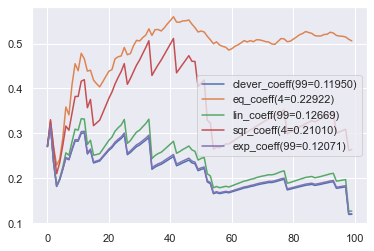

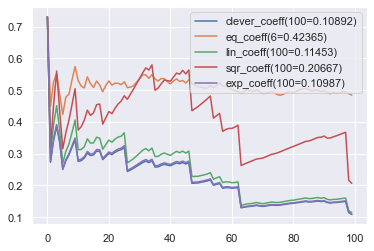

In [178]:
size = 100
for i in range(10):
    v = np.random.rand(size)
    # v = np.linspace(0.01, 0.99, size) # increace
    # v = np.linspace(0.99, 0.01, size)**2 # decreace
    # v = np.hstack([np.linspace(0.99, 0.01, size//2), np.linspace(0.01, 0.99, size//2)]) # decreace

    d = {}
    for f_coeff in [clever_coeff, eq_coeff, lin_coeff, sqr_coeff, exp_coeff]:
        f_l = [target_function(v[:i], f_coeff(v[:i])) for i in range(1, size+1)]
        d[f_coeff.__name__] = np.array(f_l)
        assert (d[f_coeff.__name__] >= d[clever_coeff.__name__]).all()

        
        plt.plot(f_l, label=f"{f_coeff.__name__}({np.argmin(f_l)+1}={np.min(f_l):.5f})")
    plt.legend()
    plt.show()

eq_coeff 6 0.32536369916165403 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.32471069338355446 0.0194515296580345
clever_coeff 6 0.32395696955774045 [0.14514848 0.17194642 0.16892933 0.172576   0.16358176 0.17781801]
0.32333946190572477 0.019667833420237295


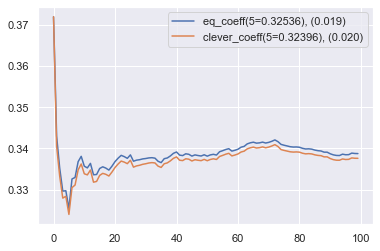

In [156]:
# np.random.seed(42)
bins = np.linspace(1, 1000, 100)
tf = cnt.get_y(np.array([bins.mean()]), np.array([True]))
ibs_l = []
auprc_l = []
sf_l = []
for i in range(100):
    s = np.random.rand(100)
    sf = np.cumsum((s/np.sum(s))[::-1])[::-1][np.newaxis, :]
    sf_l.append(sf)
    ibs_l.append(metr.ibs_WW(tf, tf, sf, bins))

ibs_l = np.array(ibs_l)
sf_l = np.vstack(sf_l)
d = {}
for f_coeff in [eq_coeff, clever_coeff]:
    L = [target_function(ibs_l[:i], f_coeff(ibs_l[:i])) for i in range(1, 101)]
    best_i = np.argmin(L) + 1
    print(f_coeff.__name__, best_i, np.min(L), f_coeff(ibs_l[:best_i]))
    fin_ibs = metr.ibs_WW(tf, tf, np.dot(sf_l[:best_i].T, f_coeff(ibs_l[:best_i]))[np.newaxis, :], bins)
    fin_auprc = metr.auprc(tf, tf, np.dot(sf_l[:best_i].T, f_coeff(ibs_l[:best_i]))[np.newaxis, :], bins)
    print(fin_ibs, fin_auprc)
    assert fin_ibs <= np.min(L)

    plt.plot(L, label=f"{f_coeff.__name__}({np.argmin(L)}={np.min(L):.5f}), ({fin_auprc:.3f})")
plt.legend()

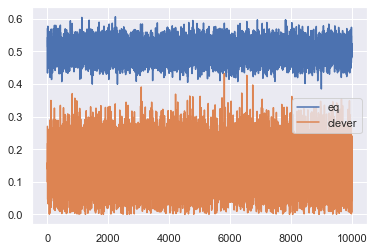

In [157]:
e_l = []
m_l = []
c_l = []

for i in range(10000):
    v = np.random.rand(100)
    e_c = target_function(v, eq_coeff(v))
    m_c = target_function(v, min_coeff(v))
    c_c = target_function(v, clever_coeff(v))
    e_l.append(e_c)
    m_l.append(m_c)
    c_l.append(c_c)
#     print(f'e_c:{e_c:.5f}, m_c:{m_c:.5f}, c_c:{c_c:.5f}')
    assert e_c > c_c
    assert m_c > c_c

# plt.plot(m_l, label="min")
plt.plot(e_l, label="eq")
plt.plot(c_l, label="clever")
plt.legend()

In [10]:
v = np.array([0.05, 0.01, 0.04])
target_function(v, eq_coeff(v))

0.06666666666666667

In [11]:
target_function(v, min_coeff(v))

0.06

In [12]:
target_function(v, clever_coeff(v))

0.04137931034482759

### IBS BOOSTING clever

In [5]:
from survivors.tree import CRAID

class IBSCRAID(CRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None
        
    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        sf = self.predict_at_times(X, self.bins, mode="surv")
        ibs_v = metr.ibs_WW(y, y, sf, self.bins, axis=0)

        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_v)
        self.ibs_leaf[counts>0]/=counts[counts>0]
        self.ibs_leaf += 1e-5
    
    def get_ibs_by_leaf(self, X, divide=False):
        numbs = self.predict(X, target="numb").astype("int")
        return self.ibs_leaf[numbs]
    
    def fit(self, X, y):
        super().fit(X, y)
        self.set_ibs_by_leaf(X, y)

In [8]:
from survivors.ensemble import BoostingCRAID
from scipy.stats import norm

class IBSCleverBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()
        
        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
#             print("UNIQUE:", np.unique(x_sub.index).shape[0])
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]  # self.weights

            model = IBSCRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
    
    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
            weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.array(res)
        weights = np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res
    
    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))
            weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.array(res)
        weights = np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res
    
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         m = metr.IBS_DICT.get(self.ens_metric_name.upper(), metr.ibs)
        m = metr.ibs_WW
        wei = m(self.y_train, y_sub, pred_sf, self.bins, axis=0) + 1e-5
        return wei, np.mean(wei)
    
    def update_weight(self, index, wei_i):
        if len(self.models) > 1:
            self.weights = 1/(1/self.weights + 1/wei_i)
        else:
            self.weights = wei_i

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            wei = 1/wei*(1/np.sum(1/wei, axis=1)).reshape(-1, 1)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)
    
    def tolerance_find_best(self, ens_metric_name="bic"):
        pass

In [9]:
a1 = np.bincount(np.array([0, 0, 0, 0]))
a2 = np.bincount(np.array([0, 0, 0, 0]), weights=np.array([0.0, 0.0, 0.0, 0.0]))
a2[a1 > 0] /= a1[a1 > 0]
a2 + 1e-15

array([1.e-15])

In [219]:
tree_m = IBSCRAID()
tree_m.fit(X_train.iloc[[0]*7,:], y_train[[0]*7])
tree_m.ibs_leaf

numbs = tree_m.predict(X_train.iloc[[0]*7,:], target="numb").astype("int")
sf = tree_m.predict_at_times(X_train.iloc[[0]*7,:], tree_m.bins, mode="surv")
ibs_v = metr.ibs_WW(y_train[[0]*7], y_train[[0]*7], sf, tree_m.bins, axis=0)

counts = np.bincount(numbs)
ibs_leaf = np.bincount(numbs, weights=ibs_v)
ibs_leaf[counts > 0] /= counts[counts > 0]
ibs_leaf

NameError: name 'X_train' is not defined

In [269]:
import sksurv.metrics
def ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0

    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time <= t,
                                      estim_before[:, i],
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    if axis == -1:  # mean ibs for each time and observation
        brier_scores = np.mean(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / time_diff
    elif axis == 1:  # bs in time (for graphics)
        return np.mean(brier_scores, axis=1)
    return None

In [270]:
from survivors.tree import CRAID
from survivors.ensemble import BoostingCRAID

class IBSCRAID(CRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None

    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        
        sf = self.predict_at_times(X, bins=self.bins, mode="surv")
        
#         time_diff = self.bins[-1] - self.bins[0] if self.bins[-1] > self.bins[0] else 1
#         ibs_ex = 1/time_diff* np.trapz(np.where(sf > 0.5, 
#                    (1 - sf)**2, (sf)**2), self.bins, axis=1)
#         ibs_ex = metr.ibs_WW(y, y, sf, self.bins, axis=0)
# #         tm = self.predict(X, target="time")
        tm = np.trapz(sf, self.bins, axis=1)
        ev = self.predict(X, target="cens")
        
        y_ = cnt.get_y(time=tm, cens=ev)
        y_["cens"] = True
        ibs_ev = metr.ibs_WW(y_, y_, sf, self.bins, axis=0)
        
        y_["cens"] = False
        ibs_cn = metr.ibs_WW(y_, y_, sf, self.bins, axis=0)
        
        ibs_ex = ibs_ev*ev + ibs_cn*(1-ev)
# #         print(tm[:5], ev[:5], sf[:5])
# #         print(ibs_ev[:5], ibs_cn[:5], ibs_ex[:5])

        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_ex)
        self.ibs_leaf[counts > 0] /= counts[counts > 0]
        self.ibs_leaf += 1e-15
        
#         self.ibs_leaf[:] = 1

    def get_ibs_by_leaf(self, X):
        numbs = self.predict(X, target="numb").astype("int")
        return self.ibs_leaf[numbs]

    def fit(self, X, y):
        super().fit(X, y)
        self.set_ibs_by_leaf(X, y)


class IBSCleverBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print("UNIQUE:", np.unique(x_sub.index).shape[0])
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]  # self.weights

            model = IBSCRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
            weights.append(self.models[i].get_ibs_by_leaf(x_test))

        res = np.array(res)
        weights = np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))
            weights.append(self.models[i].get_ibs_by_leaf(x_test))

        res = np.array(res)
        weights = np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
#         pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         #         m = metr.IBS_DICT.get(self.ens_metric_name.upper(), metr.ibs)
#         m = metr.ibs_WW
#         wei = m(self.y_train, y_sub, pred_sf, self.bins, axis=0) + 1e-2
        wei = model.get_ibs_by_leaf(X_sub)
        return wei, np.mean(wei)

    def update_weight(self, index, wei_i):
#         if len(self.models) > 1:
#             self.weights = 1 / (1 / self.weights + 1 / wei_i)
#         else:
#             self.weights = wei_i
#         pred_sf = self.predict_at_times(self.X_train, bins=self.bins, mode="surv")
        #         m = metr.IBS_DICT.get(self.ens_metric_name.upper(), metr.ibs)
#         self.weights[index] *= wei_i
        if len(self.models) > 1:
            self.weights += np.log(1/(wei_i + 1e-15))
        else:
            self.weights = np.log(1/(wei_i + 1e-15))

#         plt.scatter(self.y_train["time"], wei_i)
#         plt.scatter(self.y_train["time"], self.weights)
#         plt.show()

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
#             wei = 1 / wei * (1 / np.sum(1 / wei, axis=1)).reshape(-1, 1)
#             print(1, (1 / wei * (1 / np.sum(1 / wei, axis=1)).reshape(-1, 1))[:3])
            arr = 1/wei
            L = np.arange(1, wei.shape[1]+1)/np.cumsum(arr, axis=1)
            best_L = np.argmin(L, axis=1)

            a_ = np.ones_like(arr)*np.arange(wei.shape[1])
            a_ = np.where(a_ <= best_L.reshape((-1, 1)), arr, 0)
            wei = a_/np.sum(a_, axis=1).reshape(-1, 1)
#             print(2, wei[:3])
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

#     def tolerance_find_best(self, ens_metric_name="bic"):
#         pass

In [380]:
from survivors.tree import CRAID
from survivors.ensemble import BoostingCRAID

class IBSCRAID(CRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None

    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        
        sf = self.predict_at_times(X, bins=self.bins, mode="surv")
        
#         time_diff = self.bins[-1] - self.bins[0] if self.bins[-1] > self.bins[0] else 1
#         ibs_ex = 1/time_diff* np.trapz(np.where(sf > 0.5, 
#                    (1 - sf)**2, (sf)**2), self.bins, axis=1)
#         ibs_ex = metr.ibs_WW(y, y, sf, self.bins, axis=0)
# #         tm = self.predict(X, target="time")
        #tm = np.trapz(sf, self.bins, axis=1)
        #ev = self.predict(X, target="cens")
        
#         y_ = cnt.get_y(time=tm, cens=ev)
        y_ = y.copy()
        y_["cens"] = True
        ibs_ev = metr.ibs_WW(y, y_, sf, self.bins, axis=0)
        
        y_["cens"] = False
        ibs_cn = metr.ibs_WW(y, y_, sf, self.bins, axis=0)
        
#         ibs_ex = ibs_ev*(0.7*ev + 0.15) + ibs_cn*(0.7*(1-ev) + 0.15)
        ibs_ex = ibs_ev*0.5 + ibs_cn*0.5
# #         print(tm[:5], ev[:5], sf[:5])
# #         print(ibs_ev[:5], ibs_cn[:5], ibs_ex[:5])
        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_ex)
        self.ibs_leaf[counts > 0] /= counts[counts > 0]
#         self.ibs_leaf += 1e-15
        
#         self.ibs_leaf[:] = 1

    def get_ibs_by_leaf(self, X):
        numbs = self.predict(X, target="numb").astype("int")
        return self.ibs_leaf[numbs]

    def fit(self, X, y):
        super().fit(X, y)
        #self.set_ibs_by_leaf(X, y)


class IBSCleverBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
#             x_sub = self.X_train.groupby(cnt.CENS_NAME, 
#                                          group_keys=False).apply(lambda x: x.sample(n=self.size_sample//2, 
#                                                           replace=self.bootstrap, random_state=i))
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            '''
            sns.kdeplot(self.X_train["time"].values)
            sns.kdeplot(x_sub["time"].values)
            sns.kdeplot(x_sub["time"].values, weights=self.weights[x_sub['ind_start']])
            plt.show()
            '''
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
#                 rank_wei = self.weights.shape[0] - np.argsort(np.argsort(self.weights))
#                 X_sub_tr["weights_obs"] = rank_wei[x_sub['ind_start']]  # self.weights
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]  # self.weights
                
#             plt.scatter(x=y_sub_tr["time"], y=self.weights[x_sub['ind_start']])
#             plt.scatter(x=x_oob["time"], y=self.weights[x_oob['ind_start']])
#             plt.show()

# #             sns.kdeplot(y_sub_tr["time"])
# #             sns.kdeplot(x_oob["time"])
# #             plt.show()

            model = IBSCRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
#             X_oob, y_oob = cnt.pd_to_xy(x_oob)
            model.set_ibs_by_leaf(self.X_train.copy(), self.y_train.copy())

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
#             weights.append(self.models[i].get_ibs_by_leaf(x_test))

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))
#             weights.append(self.models[i].get_ibs_by_leaf(x_test))

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        # PRED WEI!!!
        ibs_sf = metr.ibs_WW(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        
        if len(self.bettas) > 0:
            pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
            ibs_ens = metr.ibs_WW(self.y_train, y_sub, pred_ens, self.bins)
#             betta = np.sum(ibs_ens) / np.sum(ibs_sf)
            betta = ibs_ens / np.mean(ibs_sf)
        else:
            betta = 1
        
        wei = ibs_sf
        #betta = np.mean(wei)
            
#         pred_ev = model.predict(X_sub, target="cens")

#         y_ = y_sub.copy()
#         y_["cens"] = True
#         ibs_ev = metr.ibs_WW(self.y_train, y_, pred_sf, self.bins, axis=0)
#         y_["cens"] = False
#         ibs_cn = metr.ibs_WW(self.y_train, y_, pred_sf, self.bins, axis=0)
#         ratio = np.sum(y_sub["cens"])/y_sub.shape[0]
        
# #         wei = ibs_ev*ratio + ibs_cn*(1-ratio)
#         wei = ibs_ev*0.5 + ibs_cn*0.5

#         wei = metr.ibs_WW(self.y_train, self.y_train, pred_sf, self.bins, axis=0))
#         betta = np.dot(self.weights, wei) / np.sum(self.weights)
#         wei = np.where(wei < betta, -1, 1)

#         wei = metr.ibs_WW(self.y_train, y_sub, pred_sf, self.bins, axis=0)
#         betta = np.mean(wei) # np.dot(self.weights, wei)/np.sum(self.weights)

#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         else:
#             pred_ens = np.ones_like(pred_sf)*0.5
#         betta = wei_by_ibs(self.y_train, y_sub, pred_ens, pred_sf, self.bins)
        
#         betta = metr.bal_ibs_remain(self.y_train, y_sub, pred_sf, self.bins)
#         betta = np.dot(self.weights, wei)/np.sum(self.weights)
#         wei = model.get_ibs_by_leaf(X_sub)
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
#         pass
#         if len(self.models) > 1:
# #             self.weights += self.betta[-1]*1 / (1 / self.weights + 1 / wei_i)
#             self.weights += ((1/self.bettas[-1])**2)*wei_i
#         else:
#             self.weights = ((1/self.bettas[-1])**2)*wei_i

#         if len(self.models) > 1:
#             self.weights += wei_i
#         else:
#             self.weights = wei_i

        # PRED WEI!!!
        if len(self.models) > 1:
            self.weights = self.weights + (self.bettas[-1]**2) * wei_i
            self.weights /= (1 + self.bettas[-1])**2
            self.bettas = list(np.array(self.bettas)/np.sum(self.bettas))
        else:
            self.weights = wei_i

#         plt.scatter(self.y_train["time"], self.weights)

        #pred_sf = self.predict_at_times(self.X_train, bins=self.bins, mode="surv")
#         pred_ev = self.predict(self.X_train, target="cens")
#         y_ = self.y_train.copy()
#         y_["cens"] = True
#         ibs_ev = metr.ibs_WW(self.y_train, y_, pred_sf, self.bins, axis=0)
#         y_["cens"] = False
#         ibs_cn = metr.ibs_WW(self.y_train, y_, pred_sf, self.bins, axis=0)
#         wei = ibs_ev*pred_ev + ibs_cn*(1-pred_ev)
        
#         self.weights *= np.exp(wei_i)  # metr.ibs_WW(self.y_train, self.y_train, pred_sf, self.bins, axis=0)

#         if len(self.models) > 1:
#             self.weights[index] *= wei_i
#         else:
#             self.weights = wei_i
        #self.weights = metr.ibs_WW(self.y_train, self.y_train, pred_sf, self.bins, axis=0) + 1e-5
    
#         self.weights *= np.exp(self.bettas[-1]*wei_i)
#         self.weights = self.weights/np.sum(self.weights)

        # metr.ibs_WW(self.y_train, self.y_train, pred_sf, self.bins, axis=0) + 1e-5
#         self.weights *= np.exp(metr.ibs_WW(self.y_train, self.y_train, pred_sf, self.bins, axis=0))
#         plt.scatter(self.y_train["time"], self.weights)
#         plt.show()

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
#             wei = 1 / wei * (1 / np.sum(1 / wei, axis=1)).reshape(-1, 1)
# # #             print(1, (1 / wei * (1 / np.sum(1 / wei, axis=1)).reshape(-1, 1))[:3])
# #             arr = 1/wei
# #             L = np.arange(1, wei.shape[1]+1)/np.cumsum(arr, axis=1)
# #             best_L = np.argmin(L, axis=1)

# #             a_ = np.ones_like(arr)*np.arange(wei.shape[1])
# #             a_ = np.where(a_ <= best_L.reshape((-1, 1)), arr, 0)
# #             wei = a_/np.sum(a_, axis=1).reshape(-1, 1)
# # #             print(2, wei[:3])

#             bettas = np.array(self.bettas)
#             wei = 1 / bettas * (1 / np.sum(1 / bettas))

#             wei = np.array(self.bettas) / np.sum(self.bettas)
            if wei is None:
              wei = np.array(self.bettas)
            wei = wei / np.sum(wei)

#             arr = 1/np.array(self.bettas)
#             L = np.arange(1, len(self.bettas)+1)/np.cumsum(arr)
#             best_L = np.argmin(L)
#             a_ = np.ones_like(arr)*np.arange(len(self.bettas))
#             a_ = np.where(a_ <= best_L, arr, 0)
#             wei = a_/np.sum(a_)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
#             print(wei)
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
#             print(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
#             print(wei)
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
#             print(wei)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs"):
        res = []
        metr_vals = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))

            res_all = np.array(res)
            res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
            res_all[:, -1] = 0
            res_all[:, 0] = 1
            if metric == "ibs":
                metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
            else:
                metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
        plt.plot(range(len(self.models)), metr_vals, label=label)
            
#     def tolerance_find_best(self, ens_metric_name="bic"):
#         bettas = np.array(self.bettas)
#         ind = np.argmin(np.arange(1, len(bettas)+1)/np.cumsum(1 / bettas))
#         self.select_model(0, ind + 1)

In [381]:
from numba import njit, jit
from sklearn.model_selection import train_test_split
import sksurv.metrics

@jit
def get_shared(estim, wei):
    return estim * wei

@jit
def get_before(estim, wei):
    return np.square(estim) * wei

@jit
def get_after(estim, prob_cens):
    return np.square(1 - estim) / prob_cens

def prepare_estimate(estimate, times):
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    return estimate

def count_integral(before, after, test_time, times):
    brier_scores = np.array([np.where(test_time <= t, before[:, i], after[:, i])
                             for i, t in enumerate(times)])
    brier_scores = np.mean(brier_scores, axis=1)
    return np.trapz(brier_scores, times)

def wei_by_ibs(survival_train, survival_test, estimate_ens, estimate_tree, times):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    # estimate, times = _check_estimate_2d(estimate, test_time, times)
    estimate_ens = prepare_estimate(estimate_ens, times)
    estimate_tree = prepare_estimate(estimate_tree, times)
    
#     # fit IPCW estimator
#     cens = sksurv.metrics.CensoringDistributionEstimator().fit(survival_train)
#     # calculate inverse probability of censoring weight at current time point t.
#     prob_cens_t = cens.predict_proba(times)
#     prob_cens_t[prob_cens_t == 0] = np.inf
#     # calculate inverse probability of censoring weights at observed time point
#     prob_cens_y = cens.predict_proba(test_time)
#     prob_cens_y[prob_cens_y == 0] = np.inf
    wei = test_event #  / prob_cens_y
    
    numer_before = get_shared(-estimate_tree*estimate_ens, wei[np.newaxis,:].T)
    numer_after = get_shared(estimate_tree*(1-estimate_ens), 1) # 1/prob_cens_t)
    
    denum_before = get_shared(estimate_tree*estimate_tree, wei[np.newaxis,:].T)
    denum_after = get_shared(estimate_tree*estimate_tree, 1) # 1/prob_cens_t)
    
    numer_bs = count_integral(numer_before, numer_after, test_time, times)
    denum_bs = count_integral(denum_before, denum_after, test_time, times)
    #print("NUM:", numer_bs, " DENUM:", denum_bs)
    return numer_bs/denum_bs

class BestWeiIBSBoost(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        if len(self.bettas) > 0:
            pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
            betta = abs(wei_by_ibs(self.y_train, y_sub, pred_ens, pred_sf, bins))
        else:
            betta = 1
            
        self.models.append(model)
        self.bettas.append(betta)
        
        pred_full_sf = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
        ibs_vals = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        ibs_scaled = (ibs_vals - np.mean(ibs_vals))  # first scheme
        #ibs_scaled = (ibs_vals - np.mean(ibs_vals)) / np.std(ibs_vals) # second scheme
        wei = 1/(1 + np.exp(-ibs_scaled))
        
        self.models = self.models[:-1]
        self.bettas = self.bettas[:-1]
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] * wei_i)
        #self.weights = self.weights / np.sum(self.weights)  # second scheme

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'wei':
            inv_wei = 1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

class WeiIBSBoost(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        if len(self.bettas) > 0:
            pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
        else:
            pred_ens = np.zeros_like(pred_sf)
        betta = abs(wei_by_ibs(self.y_train, y_sub, pred_ens, pred_sf, self.bins))

        self.models.append(model)
        self.bettas.append(betta)
        
        pred_full_sf = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
        ibs_vals = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        
        print("WEI:", betta, " IBS:", np.mean(ibs_vals))
        ibs_scaled = (ibs_vals - np.mean(ibs_vals))  # first scheme
        #ibs_scaled = (ibs_vals - np.mean(ibs_vals)) / np.std(ibs_vals) # second scheme
        wei = 1/(1 + np.exp(-ibs_scaled))
        # wei = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        
        self.models = self.models[:-1]
        self.bettas = self.bettas[:-1]
        return wei, betta

#     def count_model_weights(self, model, X_sub, y_sub):
#         if self.all_weight:
#             X_sub = self.X_train
#             y_sub = self.y_train
        
#         pred_tree = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         ibs_tree = metr.ibs(self.y_train, y_sub, pred_tree, self.bins, axis=-1)
#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#             ibs_ens = metr.ibs(self.y_train, y_sub, pred_ens, self.bins, axis=-1)
#             betta = ibs_ens / ibs_tree
#         else:
#             pred_ens = np.zeros_like(pred_tree)
#             betta = 1
        
#         self.models.append(model)
#         self.bettas.append(betta)
        
#         pred_full_sf = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         ibs_vals = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        
#         print("WEI:", betta, " IBS:", np.mean(ibs_vals))
#         ibs_scaled = (ibs_vals - np.mean(ibs_vals))  # first scheme
#         #ibs_scaled = (ibs_vals - np.mean(ibs_vals)) / np.std(ibs_vals) # second scheme
#         wei = 1/(1 + np.exp(-ibs_scaled))
#         # wei = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        
#         self.models = self.models[:-1]
#         self.bettas = self.bettas[:-1]
#         return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights * wei_i
        else:
            self.weights[index] = (self.weights[index] * wei_i)
        #self.weights = (self.weights - self.weights.min())
        # self.weights = self.weights / np.sum(self.weights)  # second scheme

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'wei':
            inv_wei = np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

In [382]:
# wei = np.array([[0.1, 0.05, 0.07], [0.01, 0.5, 0.001]])
# arr = 1/wei
# L = np.arange(1, wei.shape[1]+1)/np.cumsum(arr, axis=1)
# best_L = np.argmin(L, axis=1)

# a_ = np.ones_like(arr)*np.arange(wei.shape[1])
# a_ = np.where(a_ <= best_L.reshape((-1, 1)), arr, 0)
# a_ = a_/np.sum(a_, axis=1).reshape(-1, 1)
# a_, best_L

In [402]:
from sklearn.model_selection import train_test_split
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
y["time"] += 1

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

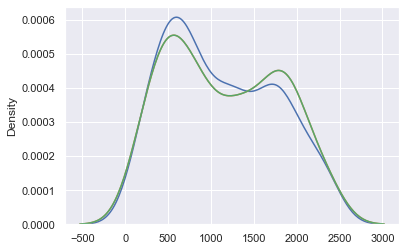

UNIQUE (0):184, DIST: [142 114]


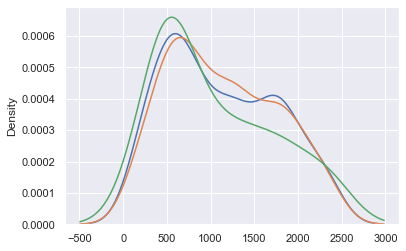

UNIQUE (1):193, DIST: [138 118]


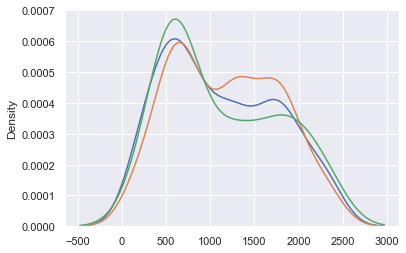

UNIQUE (2):187, DIST: [146 110]



KeyboardInterrupt



In [349]:
#param = {'aggreg_func': 'wei', 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'],
#         'criterion': 'peto', 'depth': 15, 'ens_metric_name': 'ibs_WW', 'max_features': 'sqrt',
#         'min_samples_leaf': 10, 'n_estimators': 5, 'size_sample': 0.5, 
#         "leaf_model": "base_fast", "all_weight": True}

from sklearn.model_selection import train_test_split
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

# param = {'aggreg_func': 'wei', 'categ': categ,
#          'all_weight': True, 'balance': None, 'criterion': 'maxcombo', 
#          'depth': 10, 'ens_metric_name': 'IBS', 'leaf_model': 'base_zero_after', 
#          'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'n_estimators': 10, 
#          'n_jobs': 5, 'size_sample': 0.7}
param = {'aggreg_func': 'wei', 'balance': None, 'categ': categ, 'all_weight': True, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, 
        'n_estimators': 10, 'n_jobs': 5, 'size_sample': 0.7}

# param = {'aggreg_func': 'wei', 'all_weight': True, 'balance': None, 'categ': categ, 
#  'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 'leaf_model': 'base_zero_after', 
#  'max_features': 0.3, 'min_samples_leaf': 0.05, 'n_estimators': 50, 'n_jobs': 5, 'size_sample': 1.0}

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

metr_lst = []
for X_train, y_train, X_test, y_test, bins in generate_sample(X_tr, y_tr, 5, "CV"):
    bst = IBSCleverBoostingCRAID(**param)
    bst.fit(X_train, y_train)
    bst.tolerance_find_best(param["ens_metric_name"])
    
    pred_surv = bst.predict_at_times(X_test, bins=bins, mode="surv")
    pred_time = bst.predict(X_test, target=cnt.TIME_NAME)
    pred_haz = bst.predict_at_times(X_test, bins=bins, mode="hazard")
    metr_lst.append(count_metric(y_train, y_test, pred_time,
                        pred_surv, pred_haz, bins, ['CI', "IBS_WW", "AUPRC"]))
print(np.mean(np.vstack(metr_lst), axis=0))

In [405]:
param = {'aggreg_func': 'mean', 'weighted_tree': True,
         'balance': None, 'categ': categ, 'all_weight': True,  # "only_log_rank"
         'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
         'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, 
         'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}

bst = IBSCleverBoostingCRAID(**param)
bst.fit(X_tr, y_tr) # X_tr[y_tr["cens"]], y_tr[y_tr["cens"]])
bst.tolerance_find_best(param["ens_metric_name"])

pred_surv = bst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_time = bst.predict(X_HO, target=cnt.TIME_NAME)
pred_haz = bst.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "BAL_IBS_WW", "BAL_IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

'\nbst = IBSCleverBoostingCRAID(**param)\nbst.fit(X_tr, y_tr) # X_tr[y_tr["cens"]], y_tr[y_tr["cens"]])\nbst.tolerance_find_best(param["ens_metric_name"])\n\npred_surv = bst.predict_at_times(X_HO, bins=bins_HO, mode="surv")\npred_time = bst.predict(X_HO, target=cnt.TIME_NAME)\npred_haz = bst.predict_at_times(X_HO, bins=bins_HO, mode="hazard")\nprint(count_metric(y_tr, y_HO, pred_time,\n                   pred_surv, pred_haz, bins_HO, \n                   [\'CI\', "BAL_IBS_WW", "BAL_IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))\n'

In [ ]:
[0.61872191 0.23331047 0.33394521 0.68241727 0.49935149 0.66167935]

In [ ]:
[0.63326168 0.21919794 0.37677608 0.67208202 0.49437994 0.6519517 ]

In [127]:
# [0.62548368 0.11243425 0.1544662  0.69201273 0.52570412 0.67317308]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3833433188.py, line 1)

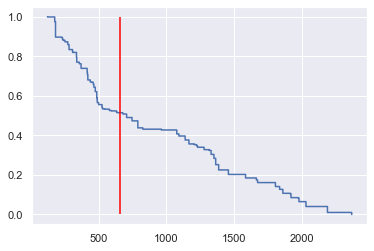

In [221]:
ind = 1
#plt.step(bins_HO, (-np.log(pred_surv))[ind])
plt.step(bins_HO, pred_surv[ind])
plt.vlines(x=y_HO[ind]["time"], ymin=0, ymax=1, color="red")

(False, 120.)


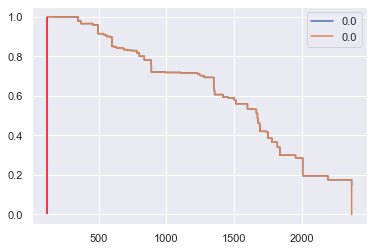

(False, 1090.)


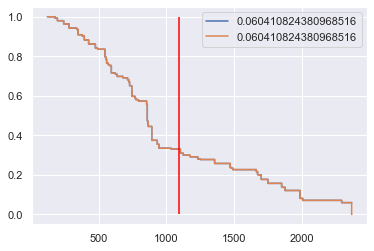

(False, 2353.)


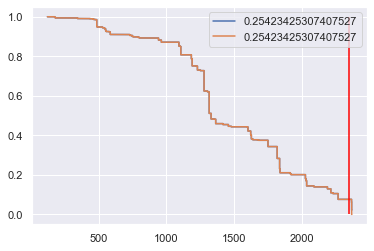

(True, 956.)


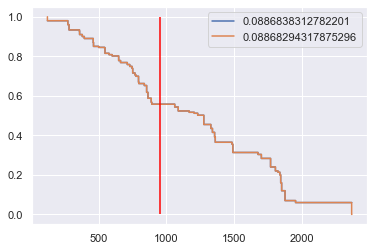

(True, 548.)


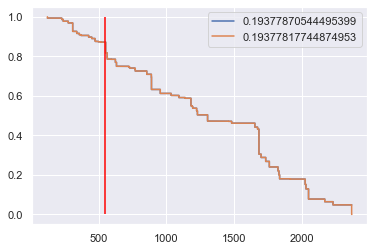

In [222]:
ibs_boost = metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)
ibs_bstr = metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)

for i in range(y_HO.shape[0])[::50]:
    print(y_HO[i])
    plt.step(bins_HO, pred_surv_bstr[i], label=ibs_bstr[i])
    plt.step(bins_HO, pred_surv[i], label=ibs_boost[i])
    plt.vlines(x=y_HO[i]["time"], ymin=0, ymax=1, color="red")
    plt.legend()
    plt.show()

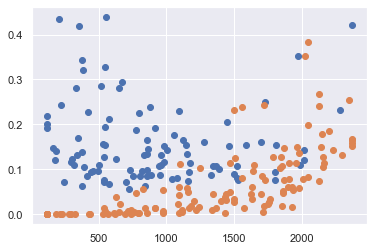

In [322]:
# plt.scatter(y_HO["time"], ibs_bstr)
plt.scatter(y_HO[y_HO["cens"] == 1]["time"], ibs_boost[y_HO["cens"] == 1])
plt.scatter(y_HO[y_HO["cens"] == 0]["time"], ibs_boost[y_HO["cens"] == 0])

(True, 1807.)
0.2511101243339254
0.18466918294849022
0.13470605004056593
0.15264987102954602
0.0
0.41665833333333335
0.39112573512906856
0.5988633701727419


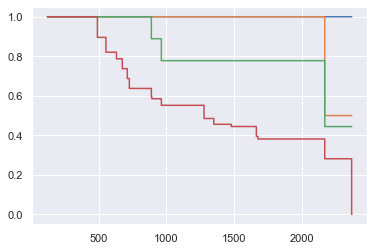

In [205]:
ind = 4
print(y_HO[ind])

sf1 = bst.models[0].predict_at_times(X_HO, bins=bins_HO, mode="surv")
sf2 = bst.models[1].predict_at_times(X_HO, bins=bins_HO, mode="surv")
sf3 = bst.models[2].predict_at_times(X_HO, bins=bins_HO, mode="surv")

plt.step(bins_HO, sf1[ind])
plt.step(bins_HO, 1/2*(sf1 + sf2)[ind])
plt.step(bins_HO, 1/3*(sf1 + sf2 + sf3)[ind])
plt.step(bins_HO, pred_surv[ind])
print(metr.ibs_WW(y_tr, y_HO, sf1, bins_HO, axis=0)[ind])
print(metr.ibs_WW(y_tr, y_HO, 1/2*(sf1 + sf2), bins_HO, axis=0)[ind])
print(metr.ibs_WW(y_tr, y_HO, 1/3*(sf1 + sf2 + sf3), bins_HO, axis=0)[ind])
print(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)[ind])

print(metr.auprc(y_tr, y_HO, sf1, bins_HO, axis=0)[ind])
print(metr.auprc(y_tr, y_HO, 1/2*(sf1 + sf2), bins_HO, axis=0)[ind])
print(metr.auprc(y_tr, y_HO, 1/3*(sf1 + sf2 + sf3), bins_HO, axis=0)[ind])
print(metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0)[ind])

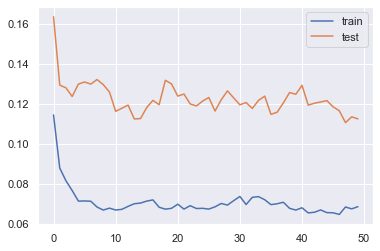

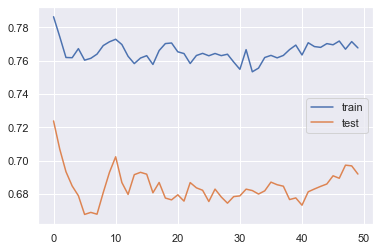

In [81]:
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "ibs")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "ibs")
plt.legend()
plt.show()
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "auprc")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "auprc")
plt.legend()

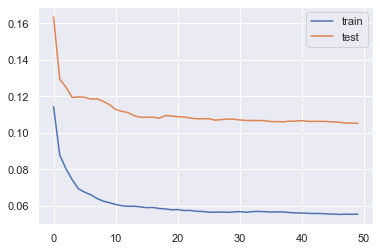

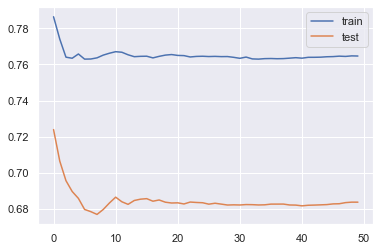

In [265]:
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "ibs")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "ibs")
plt.legend()
plt.show()
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "auprc")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "auprc")
plt.legend()

In [ ]:
[0.62548368 0.11243425 0.1544662  0.69201273 0.52570412 0.67317308]

In [ ]:
[0.75387252 0.05204882 0.07541521 0.69673459 0.44325996 0.68137249]

In [ ]:
[0.76867718 0.05066793 0.07109125 0.76937526 0.55309963 0.75626764]

In [ ]:
[0.60898964 0.11585414 0.16198742 0.69565312 0.49481666 0.67290211] # gbsg 0.001 wilcoxon depth=5
[0.60476842 0.11641855 0.16048014 0.69924151 0.52865186 0.6799169 ] # gbsg 0.001 wilcoxon depth=10

In [ ]:
[0.7740233  0.05093417 0.07049127 0.70270072 0.43617934 0.68654791] # conc
[0.76730637 0.05294268 0.07411692 0.69729963 0.43019935 0.68111174] # IBS_WW
[0.79088417 0.05039321 0.07249387 0.67134813 0.39554259 0.65463264]

In [81]:
[0.80404387 0.05268882 0.07825801 0.66458238 0.3994086  0.64851124]
[0.79417409 0.05782852 0.08732295 0.66468857 0.39489531 0.64833747]

(459, 8)

In [ ]:
[0.75030843 0.05774108 0.08062671 0.65343467 0.37750014 0.63671136]

In [ ]:
[0.78087731 0.05838152 0.08482045 0.64192989 0.39879144 0.62719423]

In [174]:
pred_time = np.trapz(pred_surv, bins_HO, axis=1)
print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

[0.73769705 0.06262648 0.09203127 0.6275045  0.38625329 0.61288321]


In [ ]:
[0.63482509 0.10441309 0.1429681  0.67109143]
[0.63482509 0.10414749 0.14249132 0.67062543]

In [ ]:
[0.62079343 0.10731633 0.1470638  0.68020601]

In [ ]:
[0.61313269 0.1096133  0.1499143  0.68883975] # logrank
[0.61815517 0.1140367  0.15687782 0.68203492] # frac
[0.60121165 0.11292009 0.1555715  0.67554147] # frac (wei)

In [ ]:
[0.6089701  0.11540998 0.15819488 0.68253505]

In [ ]:
[0.60725034 0.11271129 0.15447132 0.68202187]

In [21]:
[0.62341216 0.10677095 0.14614331 0.68388325]
[0.62904045 0.10520778 0.14410236 0.68365474]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4110907056.py, line 1)

In [ ]:
[0.62466289 0.10684377 0.14642366 0.69084193] # argwei
[0.62106703 0.10719945 0.14688103 0.68510441] # wei
[0.62458472 0.10681818 0.14638279 0.69063958] # argmean
[0.62251319 0.10718003 0.14684896 0.68484154] # mean

In [ ]:
[0.62251319 0.10718003 0.14684896 0.68484154] # mean
[0.62403752 0.11031772 0.15101997 0.6887071 ] # argmean
[0.62106703 0.10719945 0.14688103 0.68510441] # wei
[0.62388118 0.11032168 0.15102954 0.68875631] # argwei

In [ ]:
[0.63236271 0.10439156 0.14244617 0.6897557 ]

0.10792096187121013 0.6657537063221726
0.13046083235769368 0.6181510682220236
0.10758857647546498 0.6676916794431257


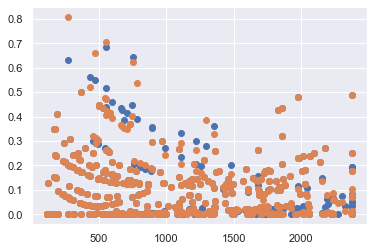

0.12889707244528278 0.6198185926391038


In [24]:
tree_m = CRAID(features=features, criterion="logrank", depth=10, min_samples_leaf=0.05)
tree_m.fit(X_tr, y_tr)

wei = metr.ibs_WW(y_tr, y_tr, 
            tree_m.predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0)

ibss = metr.ibs_WW(y_tr, y_tr, 
            tree_m.predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0)
print(ibss.mean(), metr.auprc(y_tr, y_tr, 
            tree_m.predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
            bins_HO))

ibss = metr.ibs_WW(y_tr, y_HO, 
            tree_m.predict_at_times(X_HO, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0)
print(ibss.mean(), metr.auprc(y_tr, y_HO, 
            tree_m.predict_at_times(X_HO, bins=bins_HO, mode="surv"), 
            bins_HO))

plt.scatter(y_tr["time"], wei)

X_tr_ = X_tr.copy()
X_tr_["weights_obs"] = 1 - wei  # wei # abs(y_tr["cens"] - tree_m.predict(X_tr, target="cens"))
tree_m = CRAID(features=features, criterion="logrank", depth=10, min_samples_leaf=0.05,
               weights_feature="weights_obs")
tree_m.fit(X_tr_, y_tr)
X_tr_ = X_tr_.drop(["weights_obs"], axis=1)

ibss = metr.ibs_WW(y_tr, y_tr, 
            tree_m.predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0)
print(ibss.mean(), metr.auprc(y_tr, y_tr, 
            tree_m.predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
            bins_HO))

plt.scatter(y_tr["time"], ibss)
plt.show()

ibss = metr.ibs_WW(y_tr, y_HO, 
            tree_m.predict_at_times(X_HO, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0)
print(ibss.mean(), metr.auprc(y_tr, y_HO, 
            tree_m.predict_at_times(X_HO, bins=bins_HO, mode="surv"), 
            bins_HO))

In [13]:
# [0.62286496 0.10606406 0.14576275 0.68907612]

In [34]:
ind_tr = np.argsort(metr.ibs_WW(y_tr, y_tr, 
            bst.predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0))[-10:]
ind_HO = np.argsort(metr.ibs_WW(y_tr, y_HO, 
            bst.predict_at_times(X_HO, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0))[-10:]

In [39]:
X_tr.iloc[ind_tr,:], X_HO.iloc[ind_HO,:]

(     htreat  age  menostat  tumsize  tumgrad  posnodal  prm   esm
 637       0   51         1       18        1         1   94    60
 501       1   62         2       30        2         2    5   104
 354       0   65         2       27        2         4  148   191
 172       0   31         1       28        2         2  349   189
 97        0   75         2       50        2         1  170   317
 522       1   63         2       21        1         2   16   241
 528       1   64         2       27        2         3  186   139
 144       1   62         2       19        2         1   35  1060
 498       0   53         1       20        2         2   89    36
 397       1   48         1       35        2         1  340    32,
      htreat  age  menostat  tumsize  tumgrad  posnodal  prm  esm
 662       0   49         2       22        2         1   14   41
 309       0   59         2       20        2         1    2    4
 376       0   61         2       50        2         4   10   1

In [40]:
y_tr[ind_tr], y_HO[ind_HO]

(array([( True, 801.), ( True, 369.), ( True, 594.), ( True, 285.),
        ( True, 554.), ( True, 559.), ( True, 784.), ( True, 598.),
        ( True, 481.), ( True, 755.)],
       dtype=[('cens', '?'), ('time', '<f8')]),
 array([( True,  329.), ( True,  223.), ( True, 2372.), ( True,  646.),
        ( True,  548.), ( True,  205.), ( True,  374.), ( True,  385.),
        ( True,  353.), ( True,  550.)],
       dtype=[('cens', '?'), ('time', '<f8')]))

In [121]:
# [0.62669533 0.10417038 0.67108529]
# [0.62548368 0.10382381 0.67429732]
# [0.62970491 0.10368987 0.67421918] # depth=15

In [ ]:
# [0.62368575 0.10562563 0.66351776] (50 bstr)
# [0.60777799 0.12378968 0.68154613] (10 bstr + wei min ibs + 1e-2)
# [0.60273598 0.12637439 0.68327403] (10 bstr + wei mean ibs + 1e-2)
# [0.60601915 0.12603678 0.69102384] (10 bstr + wei ibs(ET) + 1e-2)
# [0.60601915 0.12474707 0.67894255] (10 bstr + wei ibs(mean time) + 1e-2)

# [0.6013289  0.12139948 0.67901774] (10 boost + wei min ibs + 1e-2)
# [0.58692593 0.11979066 0.67487723] (10 boost + wei mean ibs + 1e-2)
# [0.59536838 0.12692    0.67587691] (10 boost + wei ibs(ET) + 1e-2)
# [0.56896619 0.12403385 0.67334499] (10 boost + wei ibs(mean time) + 1e-2)

In [28]:
metr.ibs_WW(y_tr, y_tr, 
            bst.predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
            bins_HO)

0.06101224404214838

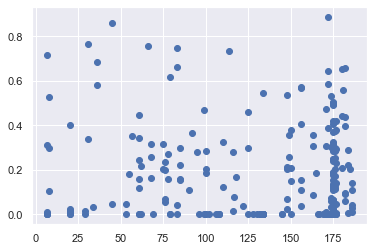

In [29]:
# plt.scatter(bst.models[1].predict(X_tr, target="numb"), metr.ibs_WW(y_tr, y_tr, 
#             bst.models[1].predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
#             bins_HO, axis=0))

plt.scatter(bst.models[1].predict(X_HO, target="numb"), metr.ibs_WW(y_tr, y_HO, 
            bst.models[1].predict_at_times(X_HO, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0))

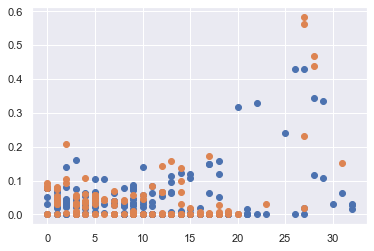

In [186]:
plt.scatter(y_tr["time"], metr.ibs_WW(y_tr, y_tr, 
            bst.predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0))

plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, 
            bst.predict_at_times(X_HO, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0))

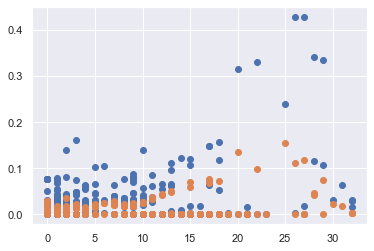

In [197]:
plt.scatter(y_tr["time"], metr.ibs_WW(y_tr, y_tr, 
            bst.predict_at_times(X_tr, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0))

plt.scatter(y_tr["time"], metr.ibs_WW(y_tr, y_tr, 
            np.array(list(map(lambda x: x(bins_HO), est.predict_survival_function(X_tr_sks)))), 
            bins_HO, axis=0))

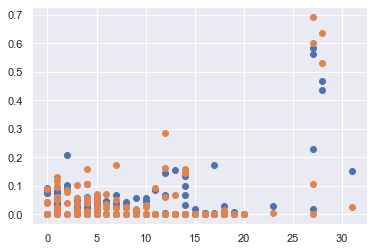

In [198]:
plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, 
            bst.predict_at_times(X_HO, bins=bins_HO, mode="surv"), 
            bins_HO, axis=0))

plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, 
            np.array(list(map(lambda x: x(bins_HO), est.predict_survival_function(X_HO_sks)))), 
            bins_HO, axis=0))

In [205]:
y_HO["time"] == 0

array([False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

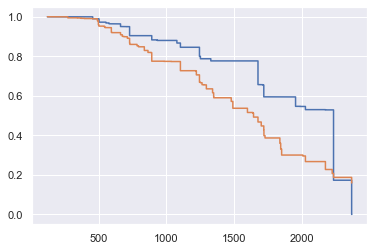

In [262]:
ibs_obs = metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)
# ibs_obs_ens = metr.auprc(y_tr, y_HO, 
#                           np.array(list(map(lambda x: x(bins_HO), est.predict_survival_function(X_HO_sks)))), 
#                           bins_HO, axis=0)

# print(np.mean(ibs_obs))
# plt.scatter(np.arange(1, y_HO.shape[0]+1), 
#             np.cumsum(np.sort(ibs_obs))/np.arange(1, y_HO.shape[0]+1))
ind = np.argmax(ibs_obs)
plt.step(bins_HO, pred_surv[ind])
plt.step(bins_HO, pred_surv_bstr[ind])
# print(y_HO[ind], ibs_obs[ind], ibs_obs_ens[ind])

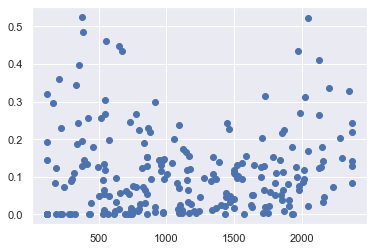

In [263]:
plt.scatter(y_HO["time"], ibs_obs)

In [268]:
ibs_obs[ind]

0.48519798720140617

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


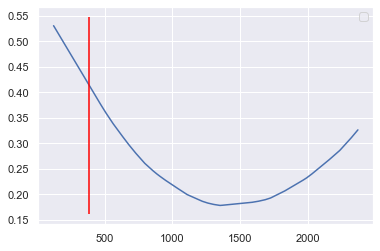

In [267]:
ind = np.argsort(ibs_obs)[-3]
y_tree_s = cnt.get_y(time=bins_HO, cens=np.ones_like(bins_HO))
y_tree_s["cens"] = True

ibs_s_by_time = np.zeros_like(bins_HO, dtype=float)
for i in range(len(bst.models)):
    MT = bst.models[i].predict(X_HO, target="time")
    sf = bst.models[i].predict_at_times(X_HO, bins=bins_HO, mode="surv")[ind]
    
    ibs_by_time = metr.ibs_WW(y_tree_s, y_tree_s, 
                              np.repeat(sf[np.newaxis, :], bins_HO.shape[0], axis=0), 
                              bins_HO, axis=0)
    ibs_s_by_time += ibs_by_time

plt.plot(bins_HO, ibs_s_by_time / len(bst.models))
ymin, ymax = plt.ylim()
plt.vlines(x=y_HO[ind]["time"], ymin=ymin, ymax=ymax, color="red")
plt.legend()

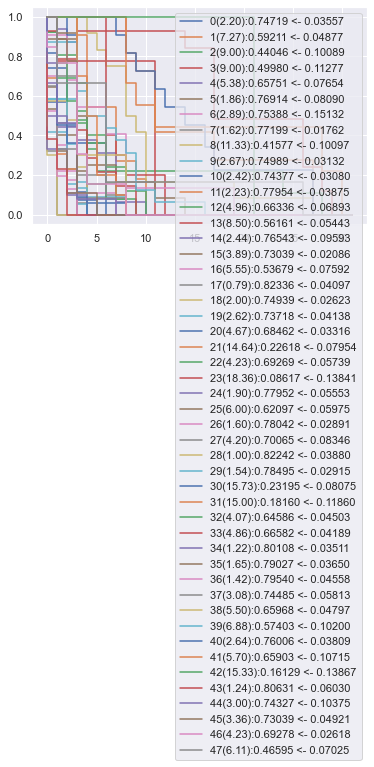

In [192]:
for i in range(len(bst.models)):
    MT = bst.models[i].predict(X_HO, target="time")
    sf = bst.models[i].predict_at_times(X_HO, bins=bins_HO, mode="surv")
    libs = bst.models[i].get_ibs_by_leaf(X_HO)
    plt.step(bins_HO, sf[ind], label=f"{i}({MT[ind]:.2f}):{metr.ibs_WW(y_tr, y_HO, sf, bins_HO, axis=0)[ind]:.5f} <- {libs[ind]:.5f}")
plt.legend()

In [108]:
s = np.zeros((bins_HO.shape[0], X_HO.shape[0]))

libs = np.ones((len(bst.models), X_HO.shape[0]))
w = np.ones((len(bst.models), X_HO.shape[0]))
DTS = np.ones((len(bst.models), X_HO.shape[0]))
for i in range(len(bst.models)):
    sf = bst.models[i].predict_at_times(X_HO, bins=bins_HO, mode="surv")
    libs[i] = bst.models[i].get_ibs_by_leaf(X_HO)
    w[i] = metr.ibs_WW(y_tr, y_HO, sf, bins_HO, axis=0)
    MT = bst.models[i].predict(X_HO, target="time")
    ET = np.trapz(sf, bins_HO, axis=1)
    DTS[i] = (MT - ET)**2

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(True, 0.)


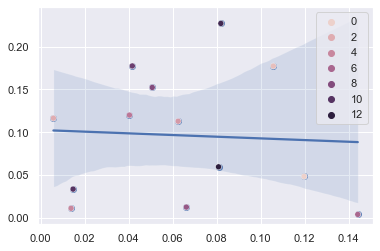

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(True, 1.)


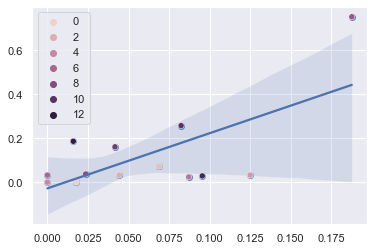

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(True, 3.)


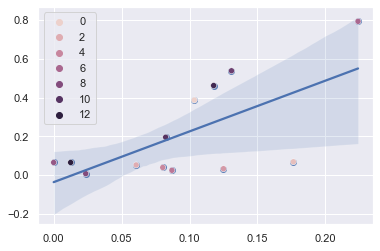

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(False, 4.)


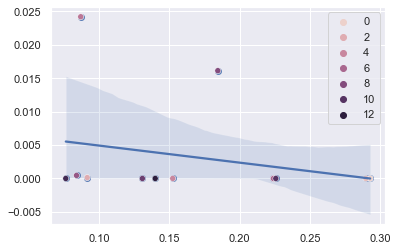

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(True, 5.)


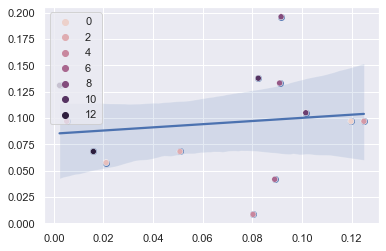

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(False, 6.)


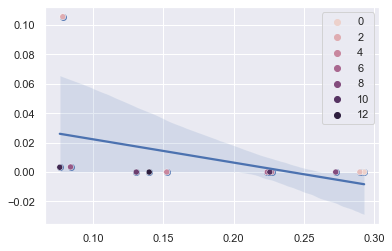

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(True, 8.)


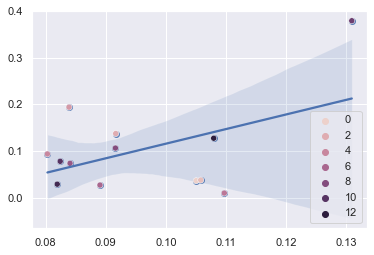

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(False, 10.)


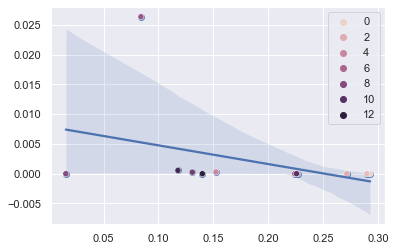

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(True, 12.)


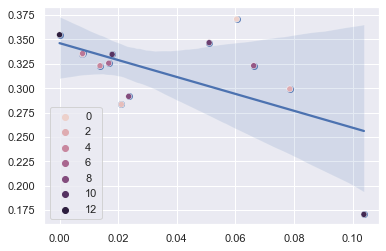

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(True, 14.)


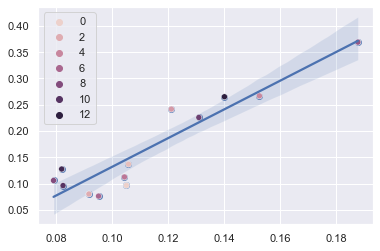

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(False, 17.)


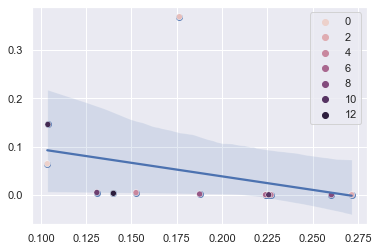

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(False, 18.)


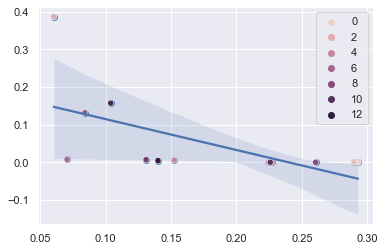

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(True, 27.)


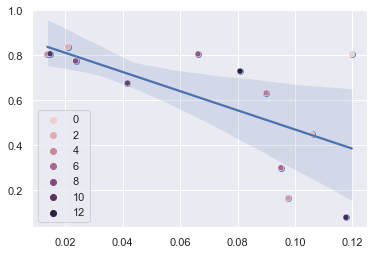

In [109]:
# for i in np.argsort(ibs_obs)[-20:]:
for i in np.argsort(y_HO["time"])[::10]:
    sns.regplot(libs.T[i], w.T[i])  # , lowess=True)
    sns.scatterplot(libs.T[i], w.T[i], hue=range(0, w.shape[0]))
    print(y_HO[i])
    plt.show()

In [224]:
from survivors.ensemble import BootstrapCRAID
param_bstr = {'balance': None, 'categ': categ, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_WW', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, # 0.01 
        'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}

bstr = BootstrapCRAID(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])

pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_time_bstr = bstr.predict(X_HO, target=cnt.TIME_NAME)
pred_haz_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time_bstr,
                   pred_surv_bstr, pred_haz_bstr, bins_HO, 
                   ['CI', "BAL_IBS_WW", "BAL_IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.1995 0.183  0.1715 0.1622 0.1537 0.1483 0.1456 0.141  0.138  0.1354
 0.1325 0.1332 0.132  0.1312 0.1301 0.1286 0.1278 0.127  0.1257 0.1259
 0.1255 0.125  0.1252 0.1247 0.1258 0.1251 0.1246 0.1248 0.1246 0.124
 0.1238 0.1235 0.1231 0.1224 0.1227 0.1227 0.1224 0.1223 0.1219 0.1215
 0.1218 0.1216 0.1215 0.121  0.1207 0.1202 0.1202 0.1201 0.1199 0.1198]
fitted: 50 models.
[0.63326168 0.21919794 0.37677608 0.67208202 0.49437994 0.6519517 ]


In [8]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
param_est = {'learning_rate': 0.5, 'loss': 'coxph', 
              'max_depth': 20, 'max_features': 'sqrt', 
              'min_samples_leaf': 20, 'n_estimators': 50, 'random_state': 123}

est = GradientBoostingSurvivalAnalysis(**param_est)
X_tr_sks = X_tr.fillna(0).replace(np.nan, 0)
X_HO_sks = X_HO.fillna(0).replace(np.nan, 0)

est = est.fit(X_tr_sks, y_tr)
survs = est.predict_survival_function(X_HO_sks)
hazards = est.predict_cumulative_hazard_function(X_HO_sks)
pred_surv_bstr = np.array(list(map(lambda x: x(bins_HO), survs)))
pred_haz_bstr = np.array(list(map(lambda x: x(bins_HO), hazards)))
pred_time_bstr = -1*est.predict(X_HO_sks)

print(count_metric(y_tr, y_HO, pred_time_bstr,
                   pred_surv_bstr, pred_haz_bstr, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

[0.76867718 0.05066793 0.07109125 0.72471607 0.4631848  0.70886569]


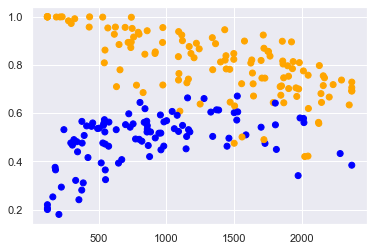

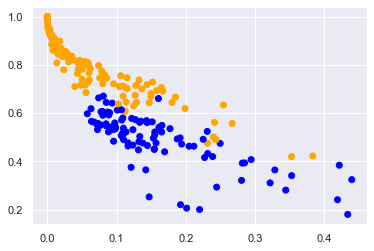

0.6681509516396956
0.10520866653160636
0.6633615107597421
0.08973665890346855


In [87]:
pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
plt.scatter(y_HO["time"], metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

In [ ]:
0.6871085428237684
0.10435569275641855
0.6970030984201783
0.08508175706337265

mean AUPRC BSTR: 0.66815
mean IBS BSTR: 0.10521
median AUPRC BSTR: 0.66336
median IBS BSTR: 0.08974
mean AUPRC BOOST: 0.60690
mean IBS BOOST: 0.12985
median AUPRC BOOST: 0.57254
median IBS BOOST: 0.10835
BAL_IBS_BSTR:0.22220
BAL_AUPRC_BSTR:0.64810
BAL_IBS_BOOST:0.26149
BAL_AUPRC_BOOST:0.59517


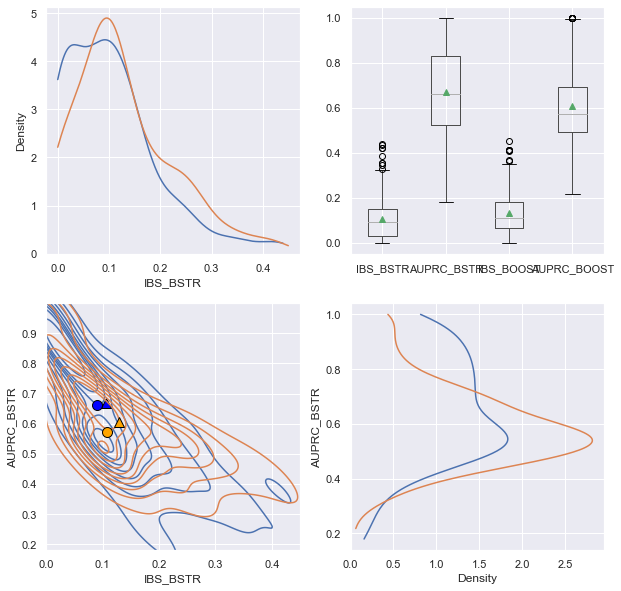

mean AUPRC BSTR: 0.49113
mean IBS BSTR: 0.15722
median AUPRC BSTR: 0.52166
median IBS BSTR: 0.13212
mean AUPRC BOOST: 0.50338
mean IBS BOOST: 0.13777
median AUPRC BOOST: 0.51658
median IBS BOOST: 0.11506


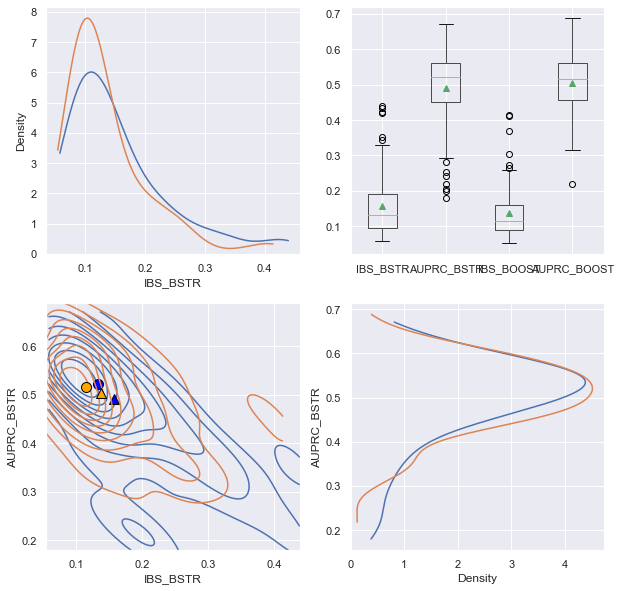

mean AUPRC BSTR: 0.80507
mean IBS BSTR: 0.06498
median AUPRC BSTR: 0.81310
median IBS BSTR: 0.03908
mean AUPRC BOOST: 0.68697
mean IBS BOOST: 0.12372
median AUPRC BOOST: 0.68096
median IBS BOOST: 0.09118


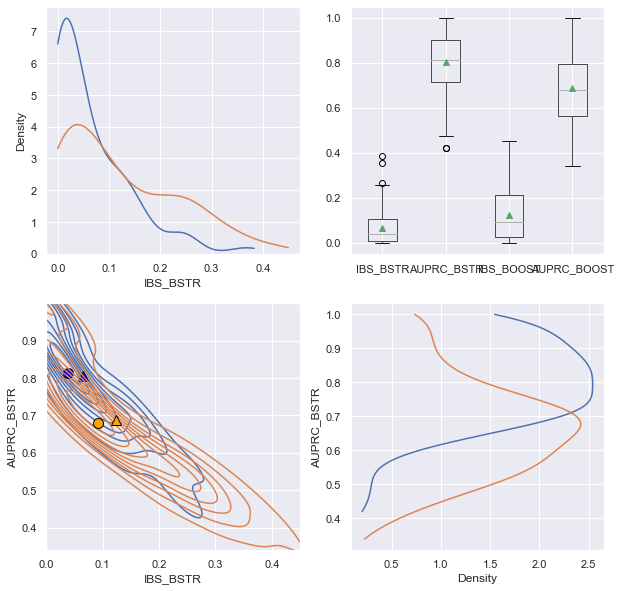

In [237]:
def analyse_quality(y_tr, y_test, l_pred_surv, bins, labels):
    df = pd.DataFrame([])
    for i, l in enumerate(labels):
        df[f"IBS_{l}"] = metr.ibs_WW(y_tr, y_test, l_pred_surv[i], bins, axis=0)
        df[f"AUPRC_{l}"] = metr.auprc(y_tr, y_test, l_pred_surv[i], bins, axis=0)
        
#     df.boxplot();
#     plt.show()
    
    fig, axes = plt.subplots(ncols=len(labels), nrows=len(labels), figsize=(10, 10))
    for l, c in zip(labels, ["blue", "orange"]):
        sns.kdeplot(data=df, x=f"IBS_{l}", y=f"AUPRC_{l}", ax=axes[1,0], cut=0)
        
        axes[1,0].plot(df[f"IBS_{l}"].mean(), df[f"AUPRC_{l}"].mean(), '^', color=c, ms=10, mec = 'black')
        axes[1,0].plot(df[f"IBS_{l}"].median(), df[f"AUPRC_{l}"].median(), 'o', color=c, ms=10, mec = 'black')
        
        sns.kdeplot(data=df, x=f"IBS_{l}", ax=axes[0,0], cut=0)
        sns.kdeplot(data=df, y=f"AUPRC_{l}", ax=axes[1,1], cut=0)
        
        for f in [np.mean, np.median]:
            for mtr in ["AUPRC", "IBS"]:
                print(f"{f.__name__} {mtr} {l}: {f(df[f'{mtr}_{l}']):.5f}")
    
    if (y_test["cens"].any() and (~y_test["cens"]).any()):
        for i, l in enumerate(labels):
            print(f"BAL_IBS_{l}:{metr.bal_ibs_WW(y_tr, y_test, l_pred_surv[i], bins):.5f}")
            print(f"BAL_AUPRC_{l}:{metr.bal_auprc(y_tr, y_test, l_pred_surv[i], bins):.5f}")

    df.boxplot(ax=axes[0,1], showmeans=True) # , vert=False)
    plt.show()

for filt in [y_HO["cens"] | True, y_HO["cens"], ~y_HO["cens"]]:
    analyse_quality(y_tr, y_HO[filt], 
                    [pred_surv_bstr[filt], pred_surv[filt]], 
                    bins_HO, ["BSTR", "BOOST"])

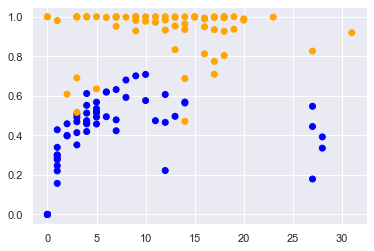

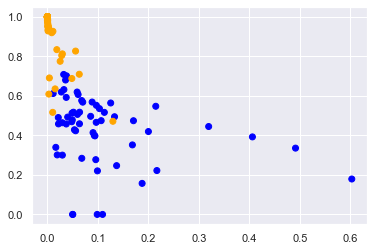

0.6972996337394312
0.05294268272922048
0.6957167177353105
0.02051289730417099


In [130]:
pred_surv = bst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
plt.scatter(y_HO["time"], metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()

plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)))

In [80]:
a = metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)
np.sum(a > np.mean(a)), np.sum(a > np.median(a))

(94, 113)

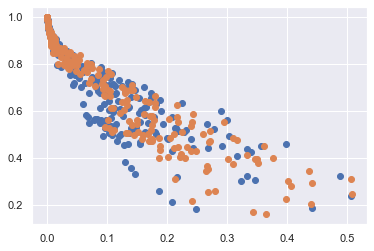

In [81]:
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0))
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0))
plt.show()

In [32]:
# base wei
# 0.6758769131025578
# 0.1269199961988582
# 0.7179428388102345
# 0.0685427525921462

# wei with best n
# 0.7074132286416197
# 0.16227732270824163
# 0.7974112156361877
# 0.06139413474638451

# wei with best n + sum ibs 
# 0.6848770018214202
# 0.16023598514630807
# 0.8212744870487891
# 0.05994671403197158

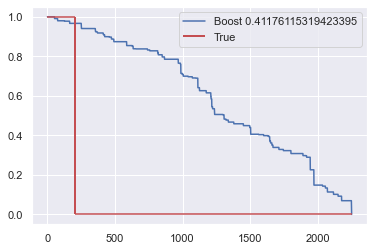

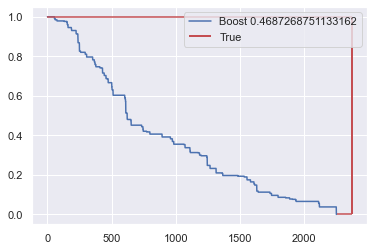

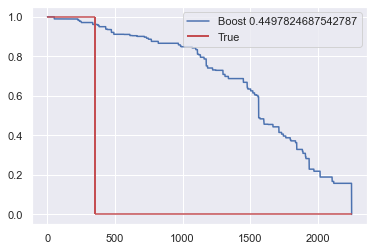

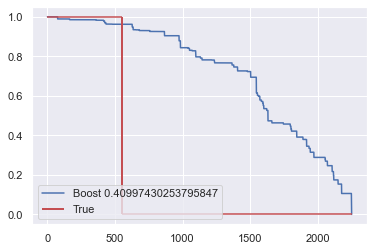

In [33]:
def print_true_pred(y_true, y_preds, labels):
    fig, ax = plt.subplots()
    
    for y_pred, label in zip(y_preds, labels):
        ax.plot(y_pred, label = label)
    ax.hlines(1.0, 0, y_true["time"], color = 'r')
    ax.hlines(0.0, y_true["time"], len(y_preds[0]), color = 'r')
    ax.vlines(y_true["time"], 0, 1, 
                  color = 'r', 
                  linestyles = ('solid' if y_true["cens"] else 'dashed'),
                  linewidth = 2, 
                  label = "True")
    ax.legend()
    plt.show()
    
# ind = np.where(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0) > 0.4)
# for i in ind:
#     y_tr[ind], pred_surv[ind]

ibs_l = metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)
worst = np.where(ibs_l > 0.4)[0][:10]
# better = np.where(ibs_l < 0.01)[0][:5]
for i in np.hstack([worst]):
    print_true_pred(y_HO[i], 
                    [pred_surv[i]],
                    [f"Boost {ibs_l[i]}"])

In [18]:
X_HO.iloc[worst]

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm
618,0,37,1,35,3,1,242,67
376,0,61,2,50,2,4,10,10
602,1,62,2,39,2,4,73,235
113,0,50,1,30,2,1,183,243


In [870]:
weights = []
for i in range(len(bst.models)):
    weights.append(bst.models[i].get_ibs_by_leaf(X_HO.iloc[worst]))

wei = np.vstack(weights).T
bounds = 1 / np.sum(1 / wei, axis=1)
# wei = 1 / wei * (1 / np.sum(1 / wei, axis=1)).reshape(-1, 1)
wei, bounds

(array([[5.30117887e-02, 2.94050863e-02, 1.04055744e-01, 9.65291647e-02,
         2.79627164e-02, 1.03479784e-01, 1.00000000e-15, 4.28939192e-02,
         1.30863324e-02, 9.30270948e-02, 7.70286348e-02, 6.19225281e-02,
         7.14567244e-02, 1.02553575e-01, 7.64686798e-02, 7.86085026e-02,
         5.47280602e-02, 9.00531063e-02, 3.96780303e-02, 4.01268733e-02,
         3.83311141e-02, 1.02366339e-01, 8.45974384e-02, 2.86396245e-02,
         1.03805470e-01, 5.48990235e-02, 8.48087324e-02, 1.23236949e-01,
         2.11442159e-02, 7.04616067e-02, 8.46422876e-02, 1.57082224e-02,
         3.50643586e-02, 7.75357301e-02, 9.78766245e-02, 2.99594062e-02,
         6.98878546e-02, 1.79874387e-02, 9.25009455e-02, 9.23472861e-02,
         6.23612960e-02, 7.90367456e-02, 2.59376387e-02, 4.27547850e-02,
         3.00221926e-02, 9.56947725e-02, 5.95277376e-02, 5.32623169e-02,
         2.33300044e-02, 7.26320462e-02],
        [5.30117887e-02, 3.53084792e-02, 5.47510147e-02, 3.41129523e-02,
         

In [270]:
weights.sum(axis=1).shape

(91,)

In [447]:
ibs_by_obs = metr.ibs_WW(y_test, y_test, pred_surv, bins, axis=0)

In [ ]:
weights = []
for i in range(len(bst.models)):
    weights.append(bst.models[i].predict(X_test))

weights = np.vstack(weights).T
bounds = 1 / np.sum(1 / weights, axis=1)

In [509]:
y_test[0]

(False, 1233.)

In [510]:
wei1 = 1 / weights1 * (1 / np.sum(1 / weights1, axis=1)).reshape(-1, 1)
wei2 = 1 / weights2 * (1 / np.sum(1 / weights2, axis=1)).reshape(-1, 1)
wei1[1], wei2[1]

(array([0.00309332, 0.025786  , 0.3172415 , 0.00858844, 0.3172415 ,
        0.3172415 , 0.00228493, 0.00239279, 0.00346641, 0.0026636 ]),
 array([0.06099068, 0.08138921, 0.08016715, 0.07429709, 0.04398791,
        0.19834669, 0.10951995, 0.10005063, 0.12933694, 0.12191376]))

In [505]:
res = []
weights = []
for i in range(len(bst.models)):
    pred_surv2 = bst.models[i].predict_at_times(X_test, bins=bins, mode="surv")
    res.append(pred_surv2)
    print(np.round(metr.ibs_WW(y_test, y_test, pred_surv2, bins, axis=0), 5), 
          bst.models[i].get_ibs_by_leaf(X_test))
#     weights.append(metr.ibs_WW(y_test, y_test, pred_surv2, bins, axis=0))
    weights.append(bst.models[i].get_ibs_by_leaf(X_test))

res = np.array(res)
weights1 = np.vstack(weights).T

bounds = 1 / np.sum(1 / weights, axis=1)
res = bst.get_aggreg(res, weights)
ibs_by_obs = metr.ibs_WW(y_test, y_test, res, bins, axis=0)

[0.13399 0.4751  0.08982 0.00427 0.21758 0.      0.01103 0.46606 0.07411
 0.46339 0.33575 0.13513 0.24556 0.      0.47439 0.07382 0.14165 0.27265
 0.19311 0.44959 0.7349  0.17102 0.13858 0.22014 0.      0.      0.14901
 0.49078 0.07096 0.00494 0.12256 0.67906 0.16419 0.43986 0.35435 0.38161
 0.02724 0.26306 0.123   0.11269 0.21909 0.17751 0.38605 0.      0.06731
 0.09325 0.17274 0.      0.      0.72136 0.06605 0.11767 0.      0.14361
 0.      0.16419 0.11978 0.01105 0.19591 0.01121 0.00104 0.33544 0.6571
 0.0192  0.13369 0.23762 0.17544 0.06785 0.14136 0.24306 0.      0.01021
 0.      0.41677 0.60718 0.      0.17275 0.      0.      0.3659  0.00944
 0.00271 0.30984 0.23224 0.15973 0.00511 0.81306 0.22835 0.2389  0.
 0.57993 0.16419] [0.08379725 0.10255698 0.06801281 0.03999378 0.001      0.001
 0.07106211 0.0732911  0.03373193 0.0732911  0.09722229 0.02337689
 0.001      0.001      0.06801281 0.00687844 0.001      0.001
 0.06632831 0.03999378 0.001      0.09722229 0.07106211 0.08379725


[1.1850e-02 2.6458e-01 4.2260e-02 5.3300e-03 7.2891e-01 0.0000e+00
 3.7200e-03 7.0830e-02 6.1027e-01 2.6640e-02 1.2078e-01 1.7496e-01
 5.4618e-01 2.0416e-01 5.2265e-01 3.8264e-01 2.9067e-01 1.5760e-01
 7.1270e-02 1.4303e-01 4.3354e-01 1.1452e-01 1.5086e-01 8.9300e-03
 5.7016e-01 1.1281e-01 7.3530e-02 8.7250e-02 1.7091e-01 8.0300e-03
 1.2473e-01 3.5741e-01 2.0650e-02 4.4630e-02 3.7314e-01 2.1670e-01
 0.0000e+00 6.1654e-01 0.0000e+00 7.6870e-02 4.2335e-01 4.0453e-01
 0.0000e+00 2.8271e-01 4.3756e-01 5.2250e-02 8.7950e-02 2.4000e-04
 8.4910e-02 8.6440e-02 1.1820e-02 2.6599e-01 5.1630e-02 6.5090e-02
 8.4800e-03 9.8510e-02 1.1979e-01 1.0300e-02 1.3658e-01 1.4239e-01
 5.7549e-01 2.3849e-01 6.6933e-01 1.3254e-01 1.4693e-01 2.3695e-01
 1.6040e-01 1.9203e-01 2.7614e-01 1.3674e-01 0.0000e+00 2.9015e-01
 2.3390e-02 1.5446e-01 5.3540e-02 9.6460e-02 1.5550e-02 1.8327e-01
 1.0380e-02 2.2669e-01 4.1900e-03 0.0000e+00 3.2244e-01 9.5120e-02
 1.0031e-01 2.9990e-02 1.6874e-01 1.1945e-01 3.7922e-01 5.3580

TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [483]:
for b, i in zip(bounds, ibs_by_obs):
    print(np.round(b*10, 5), np.round(i, 5), 10*b + 1e-5 >= i)

0.00241 0.13692 False
0.00317 0.27597 False
0.00379 0.00532 False
0.00391 0.13831 False
0.00239 0.1784 False
0.001 0.00647 False
0.00234 0.05835 False
0.00223 0.09228 False
0.00227 0.11707 False
0.00194 0.02821 False
0.00314 0.23522 False
0.00164 0.28329 False
0.00223 0.39993 False
0.00235 0.00125 True
0.00163 0.44876 False
0.00171 0.10665 False
0.00246 0.25967 False
0.0019 0.17954 False
0.00211 0.2472 False
0.00324 0.24649 False
0.00141 0.10382 False
0.00394 0.14675 False
0.00728 0.21603 False
0.00312 0.03159 False
0.00234 0.13428 False
0.00184 0.02012 False
0.00454 0.03106 False
0.00247 0.30296 False
0.00235 0.09467 False
0.00298 0.12206 False
0.00197 0.09565 False
0.00292 0.07948 False
0.00214 0.15638 False
0.00388 0.04493 False
0.00226 0.26001 False
0.00438 0.06378 False
0.00827 0.00068 True
0.00191 0.14106 False
0.00141 0.00273 False
0.00317 0.07908 False
0.00235 0.06545 False
0.00293 0.09401 False
0.00278 0.35919 False
0.00231 0.01469 False
0.00399 0.10589 False
0.00302 0.01522 F

In [341]:
res = []
weights = []
for i in range(len(bst.models)):
#     print(bst.models[i].ibs_leaf)
#     res.append(bst.models[i].predict(X, target="time"))
    res.append(bst.models[i].predict_at_times(X, bins=bins,
                                               mode="surv"))
    weights.append(bst.models[i].get_ibs_by_leaf(X))

res = np.array(res)
weights = np.vstack(weights).T

# weights, res, 
bst.get_aggreg(res, weights)

array([[1.        , 1.        , 1.        , ..., 0.09107231, 0.09107231,
        0.09107231],
       [1.        , 1.        , 1.        , ..., 0.94536287, 0.92743919,
        0.91523975],
       [1.        , 1.        , 1.        , ..., 0.76351195, 0.76351195,
        0.76351195],
       ...,
       [1.        , 1.        , 1.        , ..., 0.87007092, 0.87007092,
        0.86330681],
       [1.        , 1.        , 1.        , ..., 0.81047918, 0.81047918,
        0.81047918],
       [1.        , 1.        , 1.        , ..., 0.72988879, 0.72988879,
        0.71388379]])

In [342]:
y

array([( True,  400.), (False, 4500.), ( True, 1012.), ( True, 1925.),
       (False, 1504.), ( True, 2503.), (False, 1832.), ( True, 2466.),
       ( True, 2400.), ( True,   51.), ( True, 3762.), ( True,  304.),
       (False, 3577.), ( True, 1217.), ( True, 3584.), (False, 3672.),
       ( True,  769.), ( True,  131.), (False, 4232.), ( True, 1356.),
       (False, 3445.), ( True,  673.), ( True,  264.), ( True, 4079.),
       (False, 4127.), ( True, 1444.), ( True,   77.), ( True,  549.),
       (False, 4509.), ( True,  321.), ( True, 3839.), (False, 4523.),
       ( True, 3170.), (False, 3933.), ( True, 2847.), (False, 3611.),
       ( True,  223.), ( True, 3244.), ( True, 2297.), (False, 4467.),
       ( True, 1350.), (False, 4453.), (False, 4556.), ( True, 3428.),
       (False, 4025.), ( True, 2256.), (False, 2576.), (False, 4427.),
       ( True,  708.), ( True, 2598.), ( True, 3853.), ( True, 2386.),
       ( True, 1000.), ( True, 1434.), ( True, 1360.), ( True, 1847.),
      

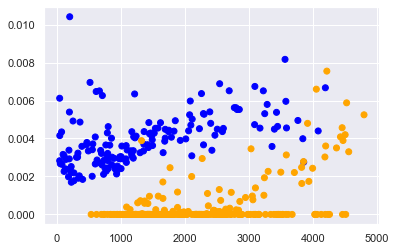

In [237]:
plt.scatter(bst.y_train["time"], bst.weights, c=np.where(bst.y_train["cens"], "blue", "orange"))

In [344]:
pred_sf = bst.predict_at_times(X, bins=bins, mode="surv")
metr.ibs(y, y, pred_sf, bins)

0.051495071595312816

In [187]:
i = bm.survival.survival_function.shape[0] - np.searchsorted(bm.survival.survival_function[::-1], 0.5)
print(i, bm.survival.survival_function[[i-1, i, i+1]])

16 [0.61688312 0.49350649 0.49350649]


In [188]:
bm.survival.timeline[i]

2234.0

2059.0
0.05020338538992599 0.05020338538992554
Integrated S(t): 297.935


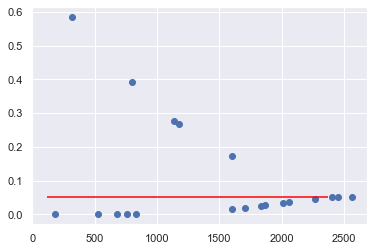

In [235]:
from survivors.tree.stratified_model import BaseFastSurviveModel, BaseFastSurviveModelZeroAfter

for i in range(1):
    X_ = X.copy()
    X_["time"] = y["time"]
    X_["cens"] = y["cens"]
    
    X_ = X_.sample(n=20)
    y_ = y[X_.index]

    bm = BaseFastSurviveModelZeroAfter()
    bm.fit(X_)
    pred_sf = bm.predict_survival_at_times(X_, bins)
    ibs_val = metr.ibs_WW(y_, y_, pred_sf, bins, axis=0)
    print(y_["time"][np.argmin(ibs_val[y_["cens"]])])
    
#     i = bm.survival.survival_function.shape[0] - np.searchsorted(bm.survival.survival_function[::-1], 0.5)
#     print(bm.survival.timeline[i], bm.survival.survival_function[[i-1, i, i+1]])

#     min_ibs = 1/(bm.survival.timeline[-1] - bm.survival.timeline[0])* np.trapz(np.where(bm.survival.survival_function[1:] >= 0.5, 
#                        (1 - bm.survival.survival_function[1:])**2, 
#                        (bm.survival.survival_function[1:])**2), bm.survival.timeline)
    min_ibs = 1/(bins[-1] - bins[0])* np.trapz(np.where(pred_sf[0] > 0.5, 
                       (1 - pred_sf[0])**2, 
                       (pred_sf[0])**2), bins)
    
    plt.scatter(y_["time"], ibs_val)
#     plt.vlines(x=np.trapz(pred_sf[0], bins), ymin=ibs_val.min(), ymax=ibs_val.max(), color="orange")
#     plt.vlines(x=bm.survival.timeline[i], ymin=ibs_val.min(), ymax=ibs_val.max(), color="green")
#     plt.vlines(x=y_[y_["cens"]]["time"][np.argmin(ibs_val[y_["cens"]])], ymin=ibs_val.min(), ymax=ibs_val.max(), color="red")
    plt.hlines(y=min_ibs, xmin=bins.min(), xmax=bins.max(), color="red")
    print(min_ibs, ibs_val[y_["cens"]].min())
    print(f"Integrated S(t): {np.trapz(ibs_val[np.argsort(y_['time'])], np.sort(y_['time'])):.3f}")

#     y_ = cnt.get_y(time=[np.trapz(pred_sf[0], bins)], cens=[True])
#     print(f"{np.trapz(pred_sf[0], bins):.3f}->{metr.ibs_WW(y_, y_, pred_sf[0][np.newaxis, :], bins):.3f}")

In [226]:
pred_sf[0], bins

(array([0.94736842, 0.94736842, 0.94736842, ..., 0.        , 0.        ,
        0.        ]),
 array([ 120,  121,  122, ..., 2370, 2371, 2372]))

In [225]:
bm.survival.survival_function, bm.survival.timeline

(array([1.        , 1.        , 0.94736842, 0.89473684, 0.84210526,
        0.78947368, 0.78947368, 0.78947368, 0.78947368, 0.78947368,
        0.78947368, 0.78947368, 0.78947368, 0.78947368, 0.67669173,
        0.67669173, 0.67669173, 0.67669173, 0.45112782, 0.45112782,
        0.45112782]),
 array([  16.,   72.,  491.,  502.,  552., 1095., 1243., 1331., 1343.,
        1350., 1483., 1632., 1653., 1753., 1786., 1852., 1904., 1918.,
        2161., 2192.]))

In [223]:
y_[y_["cens"]][np.argmin(ibs_val[y_["cens"]])]

(True, 1918.)

In [207]:
ibs_val[np.argsort(y[X_.index]["time"])]

array([5.30097656e-01, 5.27699788e-01, 4.66252220e-05, 1.26776199e-03,
       3.79564797e-01, 2.27227985e-01, 7.66906847e-03, 7.78937819e-03,
       7.90968792e-03, 8.45108168e-03, 2.04248411e-01, 9.14801635e-03,
       1.41200884e-02, 2.93376422e-02, 3.25770225e-02, 3.43850487e-02,
       3.46110520e-02, 4.03741355e-02, 4.16924879e-02, 4.19938256e-02])

In [121]:
y[X_.index]["time"]

array([1990.,  275., 1838., 1645., 1113., 1120., 1840.,  503., 2172.,
        533., 1296., 1212.,  148., 1481., 1781.,  372., 1884., 1679.,
       1722., 1729.])

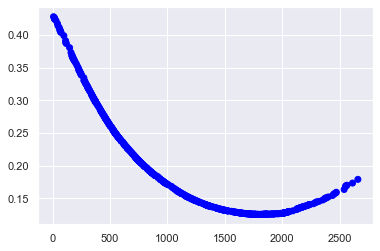

In [23]:
from survivors.tree.stratified_model import KaplanMeierZeroAfter, KaplanMeier
from survivors.constants import get_y

dur = y["time"].copy() #np.searchsorted(np.unique(y["time"]), y["time"])
dd = np.unique(dur)
cens = y["cens"]

kmf = KaplanMeierZeroAfter()
kmf.fit(dur, cens)
# y_ = get_y(cens=cens, time=dur)
# sf = kmf.survival_function_at_times(np.unique(dur))
# weights_hist = metr.ibs_WW(y_, y_, 
#                            np.repeat(sf[np.newaxis, :], dur.shape[0], axis=0), 
#                            np.unique(dur), axis=0)
# # print(np.mean(weights_hist))
# plt.scatter(y_["time"], weights_hist, c=np.where(y_["cens"], "blue", "orange"))
# # plt.scatter(y_["time"], (dur - np.trapz(sf, np.unique(dur)))**2, c=np.where(y_["cens"], "blue", "orange"))

y_ = get_y(cens=np.ones_like(dd), time=dd)
sf = kmf.survival_function_at_times(dd)
weights_hist = metr.ibs_WW(y_, y_, 
                           np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0), 
                           dd, axis=0)
plt.scatter(dd, weights_hist, c=np.where(y_["cens"], "blue", "orange"))

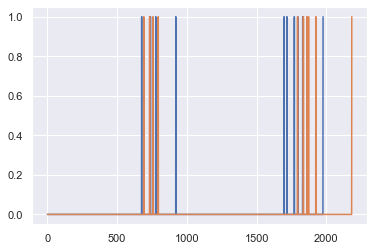

In [24]:
from sklearn.neighbors import KernelDensity

kde_sh = KernelDensity(kernel='gaussian', bandwidth=100).fit(dur[:5].reshape(-1, 1))
plt.plot(np.bincount(kde_sh.sample(n_samples=10).flatten().astype("int")))

kde_1 = KernelDensity(kernel='gaussian', bandwidth=100).fit(dur[:5][cens[:5]].reshape(-1, 1))
plt.plot(np.bincount(kde_1.sample(n_samples=10).flatten().astype("int")))

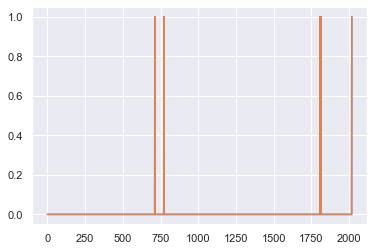

In [25]:
plt.plot(np.bincount(dur[:5].astype("int")))
plt.plot(np.bincount(dur[:5][cens[:5]].astype("int")))

In [26]:
sns.histplot(kde_1.sample(n_samples=100).flatten(), color="orange")+


SyntaxError: invalid syntax (3338758507.py, line 1)

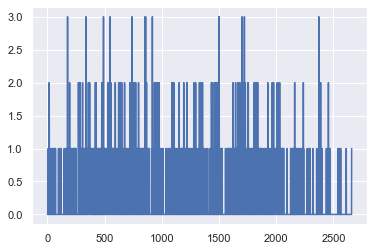

In [27]:
plt.plot(np.bincount(dur.astype("int")))

In [28]:
weights_hist

array([0.42793227, 0.42661202, 0.42510315, 0.42472593, 0.42434872,
       0.42208542, 0.41755883, 0.41435249, 0.41152337, 0.40831703,
       0.40680817, 0.40605374, 0.40492209, 0.40397905, 0.39890178,
       0.39121488, 0.3882241 , 0.38691563, 0.38057932, 0.37312485,
       0.36940887, 0.36773668, 0.36718098, 0.36644229, 0.36570586,
       0.36497169, 0.36405961, 0.36333221, 0.36260706, 0.36170345,
       0.3604384 , 0.358817  , 0.35630274, 0.35308031, 0.34985788,
       0.34735948, 0.34629215, 0.34522481, 0.34362892, 0.3422149 ,
       0.34151016, 0.34045647, 0.33923113, 0.33853321, 0.33453324,
       0.33073218, 0.33021386, 0.32969724, 0.328664  , 0.32712441,
       0.32627478, 0.32576671, 0.3245852 , 0.32323947, 0.32122088,
       0.31937678, 0.31887556, 0.31837776, 0.3170503 , 0.31556206,
       0.31456989, 0.31291629, 0.31060927, 0.30913135, 0.30799391,
       0.3070224 , 0.30621567, 0.30525105, 0.30445006, 0.30333269,
       0.30253744, 0.30222049, 0.30190583, 0.30049504, 0.29908

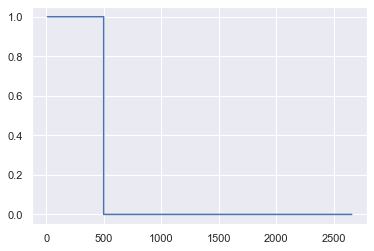

In [39]:
kmf = KaplanMeierZeroAfter()
kmf.fit(np.array([500]), np.array([True]))

plt.step(dd, kmf.survival_function_at_times(dd))
# dd = np.unique(dur)
# ET = np.trapz(kmf.survival_function_at_times(dd), dd)
# plt.plot((dd - ET)/np.sum((dd - ET)))

In [22]:
class KaplanMeier1:
    def __init__(self):
        self.timeline = None
        self.survival_function = None
        self.confidence_interval_ = None
        self.alpha = 0.05

    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_, weights=weights)*10 + 1
        self.hist_cens = np.bincount(dur_, weights=right_censor*weights)*10 + 1
        self.cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])

    def count_confidence_interval(self):
        ''' exponential Greenwood: https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf '''
        z = ss.norm.ppf(1 - self.alpha / 2)
        cumulative_sq_ = np.sqrt(np.hstack([0.0, np.cumsum(self.hist_cens / (self.cumul_hist_dur * (self.cumul_hist_dur - self.hist_cens)))]))
        np.nan_to_num(cumulative_sq_, copy=False, nan=0)
        v = np.log(self.survival_function)
        np.nan_to_num(v, copy=False, nan=0)
        self.confidence_interval_ = np.vstack([np.exp(v * np.exp(- z * cumulative_sq_ / v)),
                                               np.exp(v * np.exp(+ z * cumulative_sq_ / v))]).T
        np.nan_to_num(self.confidence_interval_, copy=False, nan=1)

    def get_confidence_interval_(self):
        if self.confidence_interval_ is None:
            self.count_confidence_interval()
        return self.confidence_interval_

    def survival_function_at_times(self, times):
        place_bin = np.digitize(times, self.timeline)
        return self.survival_function[np.clip(place_bin, 0, None)]

dd = np.unique(dur)
kmf1 = KaplanMeier()
kmf1.fit(dur[::200], cens[::200])
plt.step(dd, kmf1.survival_function_at_times(dd))

kmf2 = KaplanMeier1()
kmf2.fit(dur[::200], cens[::200])
plt.step(dd, kmf2.survival_function_at_times(dd))

NameError: name 'dur' is not defined

In [16]:
bins = np.unique(dur)

y_ = get_y(cens=cens, time=dur)

kmf1 = KaplanMeierZeroAfter()
kmf1.fit(dur[::2], cens[::2])
sf = np.ones((dur.shape[0], bins.shape[0]))
sf[::2] = kmf1.survival_function_at_times(bins)

kmf2 = KaplanMeierZeroAfter()
kmf2.fit(dur[1::2], cens[1::2])
sf[1::2] = kmf2.survival_function_at_times(bins)
np.mean(metr.ibs_WW(y_, y_, sf, bins, axis=0))

0.12578102060860186

<AxesSubplot:ylabel='Density'>

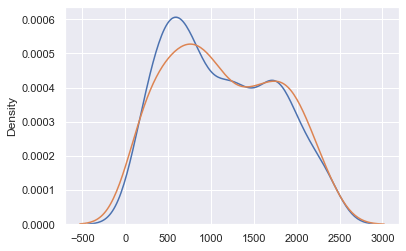

In [24]:
sns.kdeplot(y_tr["time"])
sns.kdeplot(y_HO["time"])

In [226]:
def auprc(survival_train, survival_test, estimate, times, axis=-1):
    time = survival_test["time"]
    event = survival_test["cens"]

    steps = np.linspace(1e-5, 1 - 1e-5, 100)
    before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
    after_time = time[:, np.newaxis] + np.dot(times[-1] - time[:, np.newaxis], steps[np.newaxis, :])
    print(after_time)
    before_ind = np.clip(np.searchsorted(times, before_time), 0, times.shape[0] - 1)
    after_ind = np.clip(np.searchsorted(times, after_time), 0, times.shape[0] - 1)

    est = np.take_along_axis(estimate, before_ind, axis=1)
    est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)

    if axis == -1:  # mean for each time and observation
        est = np.mean(est, axis=0)  # TODO np.mean
        return np.trapz(est, steps)
        # return np.median(np.trapz(est, steps))
    elif axis == 0:  # for each observation
        return np.trapz(est, steps)
    elif axis == 1:  # in time (for graphics)
        # est = est.median(axis=0)
        est = est.mean(axis=0)  # TODO np.mean
        return est
    elif axis == 2:  # source
        return est
    elif axis == 3:  # for each observation with array wrap
        return np.array([np.trapz(est, steps)])
    return None

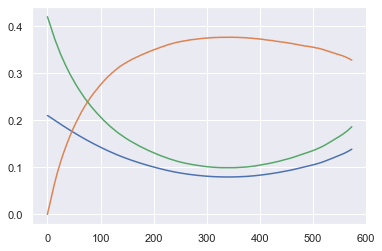

In [241]:
dur = np.searchsorted(np.unique(y["time"]), y["time"])
cens = y["cens"]

kmf = KaplanMeierZeroAfter()
kmf.fit(dur, cens)
y_ = get_y(cens=cens, time=dur)
sf = kmf.survival_function_at_times(np.unique(dur))

y_["cens"] = True
ibs_ev = metr.ibs_WW(y_, y_,
                      np.repeat(sf[np.newaxis, :], dur.shape[0], axis=0),
                      np.unique(dur), axis=0)
y_["cens"] = False
ibs_cn = metr.ibs_WW(y_, y_,
                      np.repeat(sf[np.newaxis, :], dur.shape[0], axis=0),
                      np.unique(dur), axis=0)
ratio = np.sum(cens)/cens.shape[0]
# weights_hist = ibs_ev*ratio + ibs_cn*(1-ratio)
# weights_hist = np.cumsum(np.bincount(dur, weights=weights_hist)[::-1])[::-1]
# weights_hist /= np.cumsum(np.bincount(dur)[::-1])[::-1]

weights_hist = ibs_ev*ratio + ibs_cn*(1-ratio)
weights_hist = np.bincount(dur, weights=weights_hist)
weights_hist /= np.bincount(dur)
plt.plot(weights_hist)


y_["cens"] = True
auprc_ev = metr.auprc(y_, y_,
                      np.repeat(sf[np.newaxis, :], dur.shape[0], axis=0),
                      np.unique(dur), axis=0)
y_["cens"] = False
auprc_cn = metr.auprc(y_, y_,
                      np.repeat(sf[np.newaxis, :], dur.shape[0], axis=0),
                      np.unique(dur), axis=0)
ratio = np.sum(cens)/cens.shape[0]
weights_hist2 = auprc_ev  # auprc_ev*ratio + auprc_cn*(1-ratio)
weights_hist2 = np.bincount(dur, weights=weights_hist2)
weights_hist2 /= np.bincount(dur)

plt.plot(weights_hist2)
plt.plot(weights_hist*(1-weights_hist2)*2)
                                   
# print(weights_hist)
# plt.step(np.unique(dur), sf)

# dd = np.unique(dur)
# y_ = get_y(cens=np.ones_like(dd), time=dd)
# y_["cens"] = True
# ibs_ev = metr.ibs_WW(y_, y_,
#                       np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0),
#                       dd, axis=0)
# y_["cens"] = False
# ibs_cn = metr.ibs_WW(y_, y_,
#                       np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0),
#                       dd, axis=0)
# ratio = np.sum(cens)/cens.shape[0]

# weights_hist2 = ibs_ev*ratio + ibs_cn*(1-ratio)
# ind = weights_hist != weights_hist2
# print(weights_hist[ind], weights_hist2[ind])

# c = ibs_ev[np.argmin(dur)]

# vertex = weights_hist
# plt.plot();

In [258]:
np.where(y["time"].min()/np.linspace(0.01, 0.99, 99)[::-1] < y["time"].max())[0].shape

(99,)

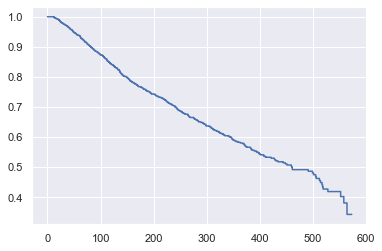

In [228]:
plt.step(np.unique(dur), sf)

In [55]:
ibs_ev[np.argmin(dur)]

0.4821650555467587

In [56]:
dur_poly.shape, weights_hist.shape

((574, 3), (574,))

[[ 0.00000000e+00 -1.01959570e-04  5.72879811e-07]] [0.00404479]
0.9989133689551808


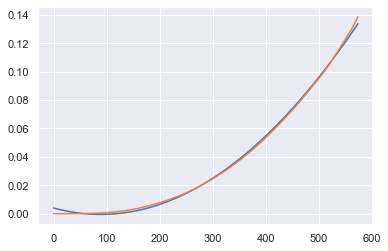

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(2)
dur_poly = poly.fit_transform(np.unique(dur).reshape(-1, 1))

regr = linear_model.LinearRegression()
regr.fit(dur_poly, weights_hist.reshape(-1, 1))
print(regr.coef_, regr.intercept_)
plt.plot(regr.predict(dur_poly))
plt.plot(weights_hist)
print(regr.score(dur_poly, weights_hist))

In [58]:
np.sum((regr.predict(dur_poly) - weights_hist.reshape(-1, 1))**2)

0.0010015517881767602

In [59]:
-regr.coef_[0][1]/(2*regr.coef_[0][2])

88.9886217285614

In [9]:

weights_hist = ibs_ev*ratio + ibs_cn*(1-ratio)
np.cumsum(np.bincount(dur, weights=weights_hist)[::-1])[::-1]

array([76.5820766 , 76.37192011, 76.16214396, 75.95312846, 75.5366188 ,
       75.32912463, 75.12239113, 74.91641829, 74.71120611, 74.50675459,
       74.30306374, 74.10013355, 73.89796403, 73.69655517, 73.49590697,
       73.29601717, 73.09688349, 72.89850367, 72.7008777 , 72.5040033 ,
       72.30788047, 72.11250692, 71.91788264, 71.72400535, 71.53087274,
       71.3384825 , 70.76353195, 70.57261719, 70.38243553, 70.19298463,
       70.00426215, 69.8162681 , 69.44173217, 69.25518793, 69.06936507,
       68.88426359, 68.69988111, 68.51621527, 68.33326607, 68.15103113,
       67.96950807, 67.7886945 , 67.60858803, 67.42918626, 67.25048679,
       66.89448766, 66.71718317, 66.54057375, 66.36465698, 66.01420876,
       65.66513611, 65.49128268, 65.31810972, 65.14561475, 64.97379533,
       64.80265146, 64.63218066, 64.29258028, 64.12344575, 63.95497687,
       63.78717115, 63.6200286 , 63.45354922, 63.2877305 , 62.79224883,
       62.62773889, 62.46387705, 62.30066077, 62.13808753, 61.97

In [16]:
df = pd.DataFrame([])

cr_l = ["ibswei", "maxcombo", "peto", "tarone-ware", "wilcoxon", "logrank"]
for cr in cr_l:
    ci_l, ibs_l, auprc_l = [], [], []
    for randstate in np.arange(1, 100):
        param = {'balance': None, 'categ': categ,
                'criterion': cr, 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
                'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, 
                'n_jobs': 5, 'size_sample': 0.7}

        X_tr_ = X_tr.copy()
        X_tr_[cnt.TIME_NAME] = y_tr[cnt.TIME_NAME]
        X_tr_[cnt.CENS_NAME] = y_tr[cnt.CENS_NAME]
        x_sub = X_tr_.sample(n=int(param["size_sample"] * X_tr_.shape[0]), replace=True, random_state=randstate)
        x_oob = X_tr_.loc[X_tr_.index.difference(x_sub.index), :]

        x_sub = x_sub.reset_index(drop=True)
        X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)

        tr = CRAID(**param)
        tr.fit(X_sub_tr, y_sub_tr)

        pred_surv = tr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
        pred_time = tr.predict(X_HO, target=cnt.TIME_NAME)
        pred_haz = tr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
        ci_el, ibs_el, auprc_el = count_metric(y_tr, y_HO, pred_time,
                           pred_surv, pred_haz, bins_HO, ['CI', "IBS_WW", "AUPRC"])
        ci_l.append(ci_el)
        ibs_l.append(ibs_el)
        auprc_l.append(auprc_el)
    df[f"{cr}_ci"] = ci_l
    df[f"{cr}_ibs"] = ibs_l
    df[f"{cr}_auprc"] = auprc_l



In [19]:
df[[f"{c_}_auprc" for c_ in cr_l]].describe()

,ibswei_auprc,maxcombo_auprc,peto_auprc,tarone-ware_auprc,wilcoxon_auprc,logrank_auprc
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.657705,0.658858,0.656532,0.656158,0.656022,0.655018
std,0.017661,0.019987,0.019164,0.019487,0.019379,0.020268
min,0.614127,0.611291,0.615151,0.604150,0.604150,0.598052
25%,0.643488,0.646592,0.645411,0.641845,0.641948,0.641308
50%,0.658488,0.659489,0.656693,0.655703,0.655993,0.658650
75%,0.669516,0.675399,0.669094,0.671595,0.667978,0.668914
max,0.701828,0.703381,0.698891,0.694390,0.693605,0.690458


In [15]:
df1 = df.copy()

In [403]:
from survivors.experiments.grid import Experiments
ho_exp = Experiments(folds=20, dataset_name="WUHAN", mode="HOLD-OUT")
ho_exp.set_metrics(["CI", "CI_CENS",
                   "IBS", "BAL_IBS", "IBS_WW", "BAL_IBS_WW", "IBS_REMAIN", "BAL_IBS_REMAIN",
                   "IAUC", "IAUC_WW", "IAUC_TI", "IAUC_WW_TI",
                   "AUPRC", "EVENT_AUPRC", "CENS_AUPRC", "BAL_AUPRC",
                   "KL", "LOGLIKELIHOOD"])
params = {k: [v] for k, v in param.items()}
params_bstr = {k: [v] for k, v in param_bstr.items()}
ho_exp.add_method(BootstrapCRAID, params_bstr)
ho_exp.add_method(IBSCleverBoostingCRAID, params)
ho_exp.run(X, y, verbose=1)
ho_exp.result_table

<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_diabetes', 'fac_cerebral', 'fac_aaa', 'fac_periph', 'fac_stenosis', 'fac_albumin', 'fac_smoking', 'fac_alcohol']], 'criterion': ['peto'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [0.7]}
[0.0954 0.0789 0.0778 0.078  0.0751 0.0726 0.0707 0.0663 0.0625 0.0635
 0.0626 0.0609 0.0587 0.0572 0.0565 0.0566 0.0563 0.0549 0.0551 0.0545
 0.0544 0.0544 0.054  0.0543 0.0541 0.0541 0.0541 0.0549 0.0553 0.0551
 0.0544 0.0539 0.0539 0.054  0.054  0.0543 0.0548 0.0547 0.0548 0.0546
 0.0545 0.0544 0.0544 0.0541 0.0538 0.0535 0.0535 0.0532 0.0531 0.0529]
fitted: 50 models.
[0.1189 0.1282 0.1159 0.107  0.1073 0.1044 0.0946 0.0855 0.0791 0.0765
 0.0763 0.0722 0.0714 0.0709 0.0695 0.0694 0.0707 0.0701 0.0692 0.069
 0.0681 0.0678 0.067  0.0674 0.0667 0.0667 0.067  0.0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:290: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 105.53886342048645 {'CI': [0.7930743357324257, 0.7922452908015949], 'CI_CENS': [0.8968672664163047, 0.9121140142517815], 'IBS': [0.13603058719895178, 0.10767585939774402], 'BAL_IBS': [0.2821437699626712, 0.2227735223791165], 'IBS_WW': [0.05497949481949098, 0.04551359087351557], 'BAL_IBS_WW': [0.11485191806490141, 0.09510388923758019], 'IBS_REMAIN': [0.08203619150981162, 0.0681352240183595], 'BAL_IBS_REMAIN': [0.24741925229565553, 0.19936842894291668], 'IAUC': [0.8565149655347565, 0.9595148456303265], 'IAUC_WW': [0.8576930193207793, 0.9588211286346483], 'IAUC_TI': [0.8571000667551721, 0.922071560085145], 'IAUC_WW_TI': [0.8614689544993865, 0.9238008199278517], 'AUPRC': [0.6441333557672104, 0.662470479573245], 'EVENT_AUPRC': [0.41629732587253815, 0.4254089042997944], 'CENS_AUPRC': [0.844352897189801, 0.8707973184499137], 'BAL_AUPRC': [0.6303251115311697, 0.6481031113748541], 'KL': [558.8516479124856, 609.8499134339096], 'LOGLIKELIHOOD': [-5

[0.0995 0.098  0.1039 0.1071 0.0989 0.0913 0.083  0.0819 0.0825 0.0814
 0.0794 0.0781 0.0775 0.0782 0.0793 0.0797 0.078  0.0786 0.079  0.0783
 0.0777 0.076  0.0756 0.0753 0.0741 0.074  0.0739 0.074  0.0734 0.0737
 0.0741 0.0739 0.0741 0.0744 0.0752 0.0745 0.0747 0.0754 0.0744 0.074
 0.0741 0.0736 0.0739 0.0735 0.0732 0.0727 0.0722 0.0723 0.0722 0.0726]
fitted: 47 models.
Iteration: 1/1
EXECUTION TIME OF IBSCleverBoostingCRAID: 29.743161916732788 {'CI': [0.7631764127459993, 0.7845455795407672], 'CI_CENS': [0.8810761878829058, 0.9129777585834593], 'IBS': [0.13166173704067372, 0.12268290380315333], 'BAL_IBS': [0.2749964995392749, 0.2519631413947413], 'IBS_WW': [0.06373318470765947, 0.05715555895861602], 'BAL_IBS_WW': [0.13407699919162322, 0.11968504929676932], 'IBS_REMAIN': [0.0911954779268694, 0.08384298761423498], 'BAL_IBS_REMAIN': [0.24165398261209767, 0.2730851479073463], 'IAUC': [0.8527869702593008, 0.963312105103231], 'IAUC_WW': [0.8563801663476535, 0.9628093735430674], 'IAUC_TI': [

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:290: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


,METHOD,PARAMS,TIME,CI,CI_CENS,IBS,BAL_IBS,IBS_WW,BAL_IBS_WW,IBS_REMAIN,...,IAUC_mean,IAUC_WW_mean,IAUC_TI_mean,IAUC_WW_TI_mean,AUPRC_mean,EVENT_AUPRC_mean,CENS_AUPRC_mean,BAL_AUPRC_mean,KL_mean,LOGLIKELIHOOD_mean
0,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_di...",105.538863,"[0.7898560657984921, 0.805085910652921, 0.8107...","[0.8839605734767025, 0.9009814612868048, 0.901...","[0.1496576020603676, 0.08698295976618689, 0.11...","[0.3111817261947012, 0.1812927049275166, 0.235...","[0.05693538685617551, 0.04569620465947125, 0.0...","[0.11874367796103291, 0.09578290637752639, 0.1...","[0.08752868563944564, 0.06617924367517897, 0.0...",...,0.861665,0.862749,0.860349,0.864586,0.645050,0.416753,0.845675,0.631214,561.401561,-507.932676
1,IBSCleverBoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': True, 'b...",29.743162,"[0.7696367374914325, 0.7803436426116839, 0.776...","[0.8691756272401434, 0.8981461286804798, 0.869...","[0.13748760627465223, 0.09210558248468194, 0.1...","[0.28738522835173913, 0.192962456400616, 0.243...","[0.06364366207844414, 0.055579500281834664, 0....","[0.13349515470534631, 0.11708731606291045, 0.1...","[0.092131822658233, 0.07769776969649157, 0.094...",...,0.858313,0.861702,0.859236,0.864100,0.661291,0.444758,0.851578,0.648168,732.375882,-472.996580


In [404]:
# WUHAN
ho_exp.result_table[[i + "_mean" for i in ["CI", "CI_CENS",
                   "IBS", "BAL_IBS", "IBS_WW", "BAL_IBS_WW", "IBS_REMAIN", "BAL_IBS_REMAIN",
                   "IAUC", "IAUC_WW", "IAUC_TI", "IAUC_WW_TI",
                   "AUPRC", "EVENT_AUPRC", "CENS_AUPRC", "BAL_AUPRC",
                   "KL", "LOGLIKELIHOOD"]]]

,CI_mean,CI_CENS_mean,IBS_mean,BAL_IBS_mean,IBS_WW_mean,BAL_IBS_WW_mean,IBS_REMAIN_mean,BAL_IBS_REMAIN_mean,IAUC_mean,IAUC_WW_mean,IAUC_TI_mean,IAUC_WW_TI_mean,AUPRC_mean,EVENT_AUPRC_mean,CENS_AUPRC_mean,BAL_AUPRC_mean,KL_mean,LOGLIKELIHOOD_mean
0,0.793033,0.897630,0.134613,0.279175,0.054506,0.113865,0.081341,0.245017,0.861665,0.862749,0.860349,0.864586,0.645050,0.416753,0.845675,0.631214,561.401561,-507.932676
1,0.764245,0.882671,0.131213,0.273845,0.063404,0.133357,0.090828,0.243226,0.858313,0.861702,0.859236,0.864100,0.661291,0.444758,0.851578,0.648168,732.375882,-472.996580


In [393]:
# GBSG
ho_exp.result_table[[i + "_mean" for i in ["CI", "CI_CENS",
                   "IBS", "BAL_IBS", "IBS_WW", "BAL_IBS_WW", "IBS_REMAIN", "BAL_IBS_REMAIN",
                   "IAUC", "IAUC_WW", "IAUC_TI", "IAUC_WW_TI",
                   "AUPRC", "EVENT_AUPRC", "CENS_AUPRC", "BAL_AUPRC",
                   "KL", "LOGLIKELIHOOD"]]]

,CI_mean,CI_CENS_mean,IBS_mean,BAL_IBS_mean,IBS_WW_mean,BAL_IBS_WW_mean,IBS_REMAIN_mean,BAL_IBS_REMAIN_mean,IAUC_mean,IAUC_WW_mean,IAUC_TI_mean,IAUC_WW_TI_mean,AUPRC_mean,EVENT_AUPRC_mean,CENS_AUPRC_mean,BAL_AUPRC_mean,KL_mean,LOGLIKELIHOOD_mean
0,0.620036,0.683199,0.185415,0.377272,0.110600,0.234698,0.148697,0.387286,0.692205,0.698719,0.724090,0.732824,0.656371,0.471364,0.799462,0.635413,1149.549218,-2301.030972
1,0.623783,0.688457,0.174485,0.362931,0.112847,0.243636,0.152943,0.359419,0.703361,0.709666,0.733615,0.742829,0.668741,0.483708,0.811853,0.647781,1342.696048,-2326.535783


In [14]:
from survivors.experiments.grid import Experiments
ho_exp = Experiments(folds=20, dataset_name="WUHAN", mode="HOLD-OUT")
ho_exp.set_metrics(['CI', "IBS_WW", "IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"])
params = {k: [v] for k, v in param.items()}
params_est = {k: [v] for k, v in param_est.items()}
ho_exp.add_method(GradientBoostingSurvivalAnalysis, params_est)
ho_exp.add_method(IBSCleverBoostingCRAID, params)
ho_exp.run(X, y, verbose=1)
ho_exp.result_table

<class 'sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis'> {'learning_rate': [0.5], 'loss': ['coxph'], 'max_depth': [20], 'max_features': ['sqrt'], 'min_samples_leaf': [20], 'n_estimators': [50], 'random_state': [123]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:290: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF GradientBoostingSurvivalAnalysis: 1.6353802680969238 {'CI': [0.7609008067800538, 0.760415234428709], 'IBS_WW': [0.04896887937019225, 0.03919703511189678], 'IBS_REMAIN': [0.06783375312861804, 0.054520540858832664], 'AUPRC': [0.7756174458141585, 0.790662265398092], 'EVENT_AUPRC': [0.5618303916597123, 0.5807139038511239], 'BAL_AUPRC': [0.7626606546532829, 0.7779381222740334]}
<class '__main__.IBSCleverBoostingCRAID'> {'aggreg_func': ['wei'], 'weighted_tree': [False], 'balance': [None], 'categ': [[]], 'all_weight': [True], 'criterion': ['peto'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.05], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [0.7]}
Fitted from scratch
UNIQUE (0):120, DIST: [93 82]
UNIQUE (1):128, DIST: [97 78]
UNIQUE (2):126, DIST: [89 86]
UNIQUE (3):127, DIST: [94 81]
UNIQUE (4):128, DIST: [97 78]
UNIQUE (5):126, DIST: [93 82]
UNIQUE (6):119, DIST: [94 81

UNIQUE (49):130, DIST: [83 92]
[0.0683 0.0737 0.0822 0.0732 0.0701 0.0698 0.0701 0.0666 0.0632 0.0634
 0.0615 0.0599 0.0594 0.0599 0.06   0.0591 0.06   0.0601 0.0601 0.0602
 0.0598 0.0598 0.0596 0.0592 0.0588 0.0583 0.0585 0.0585 0.0581 0.0584
 0.0583 0.0581 0.058  0.058  0.0583 0.0577 0.0575 0.0574 0.0578 0.0577
 0.0577 0.0577 0.0579 0.0581 0.0581 0.0581 0.0576 0.0578 0.058  0.0577]
fitted: 38 models.
Fitted from scratch
UNIQUE (0):120, DIST: [91 84]
UNIQUE (1):128, DIST: [104  71]
UNIQUE (2):126, DIST: [89 86]
UNIQUE (3):127, DIST: [85 90]
UNIQUE (4):128, DIST: [92 83]
UNIQUE (5):126, DIST: [100  75]
UNIQUE (6):119, DIST: [98 77]
UNIQUE (7):128, DIST: [90 85]
UNIQUE (8):128, DIST: [101  74]
UNIQUE (9):121, DIST: [102  73]
UNIQUE (10):134, DIST: [98 77]
UNIQUE (11):118, DIST: [94 81]
UNIQUE (12):126, DIST: [92 83]
UNIQUE (13):131, DIST: [85 90]
UNIQUE (14):123, DIST: [93 82]
UNIQUE (15):132, DIST: [99 76]
UNIQUE (16):128, DIST: [93 82]
UNIQUE (17):128, DIST: [78 97]
UNIQUE (18):121, D

Fitted from scratch
UNIQUE (0):120, DIST: [107  68]
UNIQUE (1):128, DIST: [96 79]
UNIQUE (2):126, DIST: [98 77]
UNIQUE (3):127, DIST: [99 76]
UNIQUE (4):128, DIST: [106  69]
UNIQUE (5):126, DIST: [99 76]
UNIQUE (6):119, DIST: [92 83]
UNIQUE (7):128, DIST: [98 77]
UNIQUE (8):128, DIST: [95 80]
UNIQUE (9):121, DIST: [97 78]
UNIQUE (10):134, DIST: [99 76]
UNIQUE (11):118, DIST: [106  69]
UNIQUE (12):126, DIST: [100  75]
UNIQUE (13):131, DIST: [103  72]
UNIQUE (14):123, DIST: [93 82]
UNIQUE (15):132, DIST: [81 94]
UNIQUE (16):128, DIST: [88 87]
UNIQUE (17):128, DIST: [90 85]
UNIQUE (18):121, DIST: [99 76]
UNIQUE (19):130, DIST: [90 85]
UNIQUE (20):127, DIST: [97 78]
UNIQUE (21):131, DIST: [93 82]
UNIQUE (22):131, DIST: [94 81]
UNIQUE (23):121, DIST: [97 78]
UNIQUE (24):130, DIST: [102  73]
UNIQUE (25):125, DIST: [96 79]
UNIQUE (26):124, DIST: [92 83]
UNIQUE (27):133, DIST: [103  72]
UNIQUE (28):123, DIST: [76 99]
UNIQUE (29):127, DIST: [89 86]
UNIQUE (30):121, DIST: [97 78]
UNIQUE (31):126

UNIQUE (11):118, DIST: [90 85]
UNIQUE (12):126, DIST: [107  68]
UNIQUE (13):131, DIST: [96 79]
UNIQUE (14):123, DIST: [109  66]
UNIQUE (15):132, DIST: [92 83]
UNIQUE (16):128, DIST: [88 87]
UNIQUE (17):128, DIST: [98 77]
UNIQUE (18):121, DIST: [87 88]
UNIQUE (19):130, DIST: [93 82]
UNIQUE (20):127, DIST: [99 76]
UNIQUE (21):131, DIST: [96 79]
UNIQUE (22):131, DIST: [96 79]
UNIQUE (23):121, DIST: [95 80]
UNIQUE (24):130, DIST: [101  74]
UNIQUE (25):125, DIST: [101  74]
UNIQUE (26):124, DIST: [92 83]
UNIQUE (27):133, DIST: [90 85]
UNIQUE (28):123, DIST: [88 87]
UNIQUE (29):127, DIST: [98 77]
UNIQUE (30):121, DIST: [100  75]
UNIQUE (31):126, DIST: [98 77]
UNIQUE (32):130, DIST: [105  70]
UNIQUE (33):137, DIST: [97 78]
UNIQUE (34):126, DIST: [90 85]
UNIQUE (35):125, DIST: [89 86]
UNIQUE (36):127, DIST: [96 79]
UNIQUE (37):131, DIST: [94 81]
UNIQUE (38):130, DIST: [96 79]
UNIQUE (39):120, DIST: [103  72]
UNIQUE (40):127, DIST: [94 81]
UNIQUE (41):126, DIST: [97 78]
UNIQUE (42):122, DIST: [1

UNIQUE (23):121, DIST: [94 81]
UNIQUE (24):130, DIST: [97 78]
UNIQUE (25):125, DIST: [100  75]
UNIQUE (26):124, DIST: [90 85]
UNIQUE (27):133, DIST: [85 90]
UNIQUE (28):123, DIST: [99 76]
UNIQUE (29):127, DIST: [83 92]
UNIQUE (30):121, DIST: [105  70]
UNIQUE (31):126, DIST: [96 79]
UNIQUE (32):130, DIST: [88 87]
UNIQUE (33):137, DIST: [85 90]
UNIQUE (34):126, DIST: [81 94]
UNIQUE (35):125, DIST: [99 76]
UNIQUE (36):127, DIST: [95 80]
UNIQUE (37):131, DIST: [98 77]
UNIQUE (38):130, DIST: [96 79]
UNIQUE (39):120, DIST: [100  75]
UNIQUE (40):127, DIST: [101  74]
UNIQUE (41):126, DIST: [88 87]
UNIQUE (42):122, DIST: [92 83]
UNIQUE (43):123, DIST: [97 78]
UNIQUE (44):131, DIST: [94 81]
UNIQUE (45):128, DIST: [103  72]
UNIQUE (46):127, DIST: [81 94]
UNIQUE (47):118, DIST: [86 89]
UNIQUE (48):129, DIST: [83 92]
UNIQUE (49):130, DIST: [97 78]
[0.0958 0.0826 0.0804 0.0826 0.0756 0.0703 0.0698 0.0654 0.0631 0.0621
 0.0602 0.0592 0.0588 0.0591 0.059  0.0595 0.0591 0.0591 0.0575 0.0571
 0.0567 0.0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:290: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


,METHOD,PARAMS,TIME,CI,IBS_WW,IBS_REMAIN,AUPRC,EVENT_AUPRC,BAL_AUPRC,CRIT,CI_mean,IBS_WW_mean,IBS_REMAIN_mean,AUPRC_mean,EVENT_AUPRC_mean,BAL_AUPRC_mean
0,GradientBoostingSurvivalAnalysis,"{'learning_rate': 0.5, 'loss': 'coxph', 'max_d...",1.63538,"[0.7686771761480466, 0.7626116838487973, 0.780...","[0.050667931301829616, 0.0449161604429137, 0.0...","[0.07109124769641434, 0.05952045384313097, 0.0...","[0.7693752584693023, 0.7763242730689449, 0.791...","[0.5530996288534009, 0.5526763672745774, 0.588...","[0.7562676445531873, 0.7627698545359529, 0.779...",,0.760877,0.048480,0.067168,0.776370,0.562775,0.763425
1,IBSCleverBoostingCRAID,"{'aggreg_func': 'wei', 'all_weight': True, 'ba...",1166.746485,"[0.7538725154215216, 0.7726460481099656, 0.789...","[0.052048821616453925, 0.049336072081921534, 0...","[0.0754152075318347, 0.06865000547035537, 0.08...","[0.7475308350292171, 0.7453298436552149, 0.740...","[0.5423170864862754, 0.49983435105426566, 0.51...","[0.7350936381478266, 0.7304513289521273, 0.726...",peto,0.762779,0.058106,0.084739,0.730671,0.510468,0.717325


In [ ]:
[0.75387252 0.05204882 0.07541521 0.74753084 0.54231709 0.73509364]